In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install matplotlib --upgrade
import shutil
import os
import numpy as np
from glob import glob
import re
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV


#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
# warnings.filterwarnings("ignore", category=np.DeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
    dropfeat = [i.replace('\n','') for i in d.readlines()]

In [3]:
with open('test_ind.pickle', 'rb') as handle:
    test_ind = pickle.load(handle)

with open('train_ind.pickle', 'rb') as handle:
    train_ind = pickle.load(handle)
    
print(len(train_ind),len(test_ind))    


70 30


/tmp/ipykernel_384437/2691449218.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  test_ind = pickle.load(handle)
/tmp/ipykernel_384437/2691449218.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is th

In [4]:
len(train_ind)*len(glob('H*')),len(test_ind)*len(glob('H*'))

(560, 240)

In [5]:
len(train_ind)*len([i for i in glob('H*') if '12' not in i]),len(test_ind)*len([i for i in glob('H*') if '12' not in i])

(490, 210)

In [6]:
train = []
test = []



recover_train = []
recover_test = []

traincnt = 0
testcnt = 0
for i in sorted(glob('H*')):

    for j in glob(os.path.join(i,'H*')):
        for k in train_ind:
            if f"{k:.2f}" in j:
                traindf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0)
                train.append(traindf)
                recover_train.append((i,f"{k:.2f}",traincnt,len(traindf)))
                traincnt+=1
                
        for l in test_ind:
            if f"{l:.2f}" in j:
                testdf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0)
                test.append(testdf)                    
                recover_test.append((i,f"{l:.2f}",testcnt,len(testdf)))
                testcnt+=1

In [7]:
rename = {'h$_{qq}^{0}$':'h$_{q}$',
'$(F_{q})_{0}$':'$F_{q}$',
'$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
'$(\\eta_{q})_{0}$':'$\\eta_{q}$',
'$(\\omega_{q})_{0}$':'$\\omega_{q}$',
'$(\\eta_{s})_{0}$':'$\\eta_{s}$',
'h$_{ss}^{0}$':'h$_{s}$',
'$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
'$(F_{s})_{0}$':'$F_{s}$',
'$(\\omega_{s})_{0}$':'$\\omega_{s}$',
'$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
'$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
'h$_{pp}^{0}$': 'h$_{p}^{0}$',
'h$_{pp}^{1}$': 'h$_{p}^{1}$',
'h$_{pp}^{2}$': 'h$_{p}^{2}$',
'h$_{pp}^{3}$': 'h$_{p}^{3}$',
'h$_{rr}^{0}$': 'h$_{r}^{0}$',
'h$_{rr}^{1}$': 'h$_{r}^{1}$',
'h$_{rr}^{2}$': 'h$_{r}^{2}$',
'h$_{rr}^{3}$': 'h$_{r}^{3}$'}

In [8]:
train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)

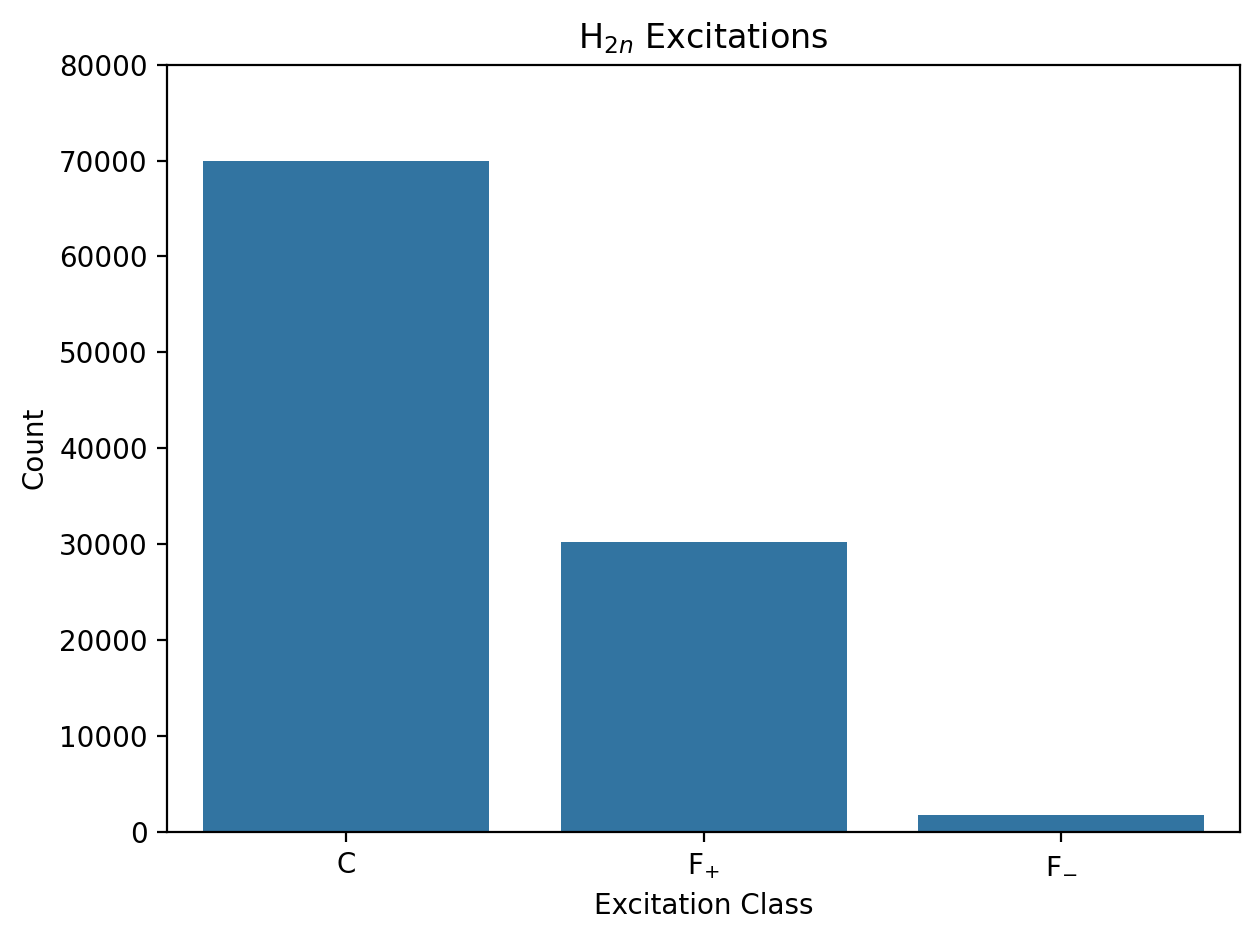

In [9]:
counttypes=pd.concat([train_df[i].value_counts() for i in train_df.columns if 'typ' in i],axis=1).T.sum(axis=0).sort_index()
counttypes.index=[{1:"A", 2:"B$_{+}$", 3:"B$_{-}$", 4:"C", 5:"D", 6:"E$_{+}$", 7:"E$_{-}$", 8:"F$_{+}$", 9:"F$_{-}$", 10:"G$_{+}$", 11:"G$_{-}$", 12:"H$_{+}$", 13:"H$_{-}$"}[t] for t in counttypes.index+1]
sns.barplot(data=counttypes.reset_index(),x='index',y=0,color=sns.color_palette('Paired')[1])
plt.ylabel('Count')
plt.xlabel('Excitation Class')
plt.ylim(0,8e4)
plt.title('H$_{2n}$ Excitations')
plt.tight_layout()
plt.savefig('images/excitation_barplot.png',dpi=300,bbox_inches='tight')
plt.show()

In [10]:
X_train = train_df.drop(columns=['Pair_Energies']).values
X_test = test_df.drop(columns=['Pair_Energies']).values

y_train = train_df['Pair_Energies'].values
y_test = test_df['Pair_Energies'].values

In [11]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [12]:
from xgboost import XGBRegressor

# kwargs = dict(pd.read_excel("H2n_params.xlsx").values)
# model=XGBRegressor(**kwargs)
# model.fit(X_train,y_train)
# y_pred_train=model.predict(X_train)
# y_pred_test=model.predict(X_test)
# print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
# print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")

params = {'max_depth': [1, 10, 100],
          'n_estimators': [100, 500, 1000],
          'reg_lambda': [1e-6, 1e-3,1e-1],
          'reg_alpha': [1e-6, 1e-3,1e-1]}

model = XGBRegressor()
grid = GridSearchCV(estimator=model, 
                   param_grid=params,
                   scoring='r2', 
                   verbose=0,n_jobs=12).fit(X_train,y_train)


model=grid.best_estimator_
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")
pd.DataFrame.from_dict(model.get_params(),orient='index').dropna().to_excel("H2n_params.xlsx")

/home/grierjones/miniconda3/envs/DDGNN/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


R2: 0.9926,0.9826
RMSE (mEh): 0.1004,0.1625


In [13]:
pd.DataFrame.from_dict(model.get_params(),orient='index').dropna().to_excel("H2n_VDZP_params.xlsx")

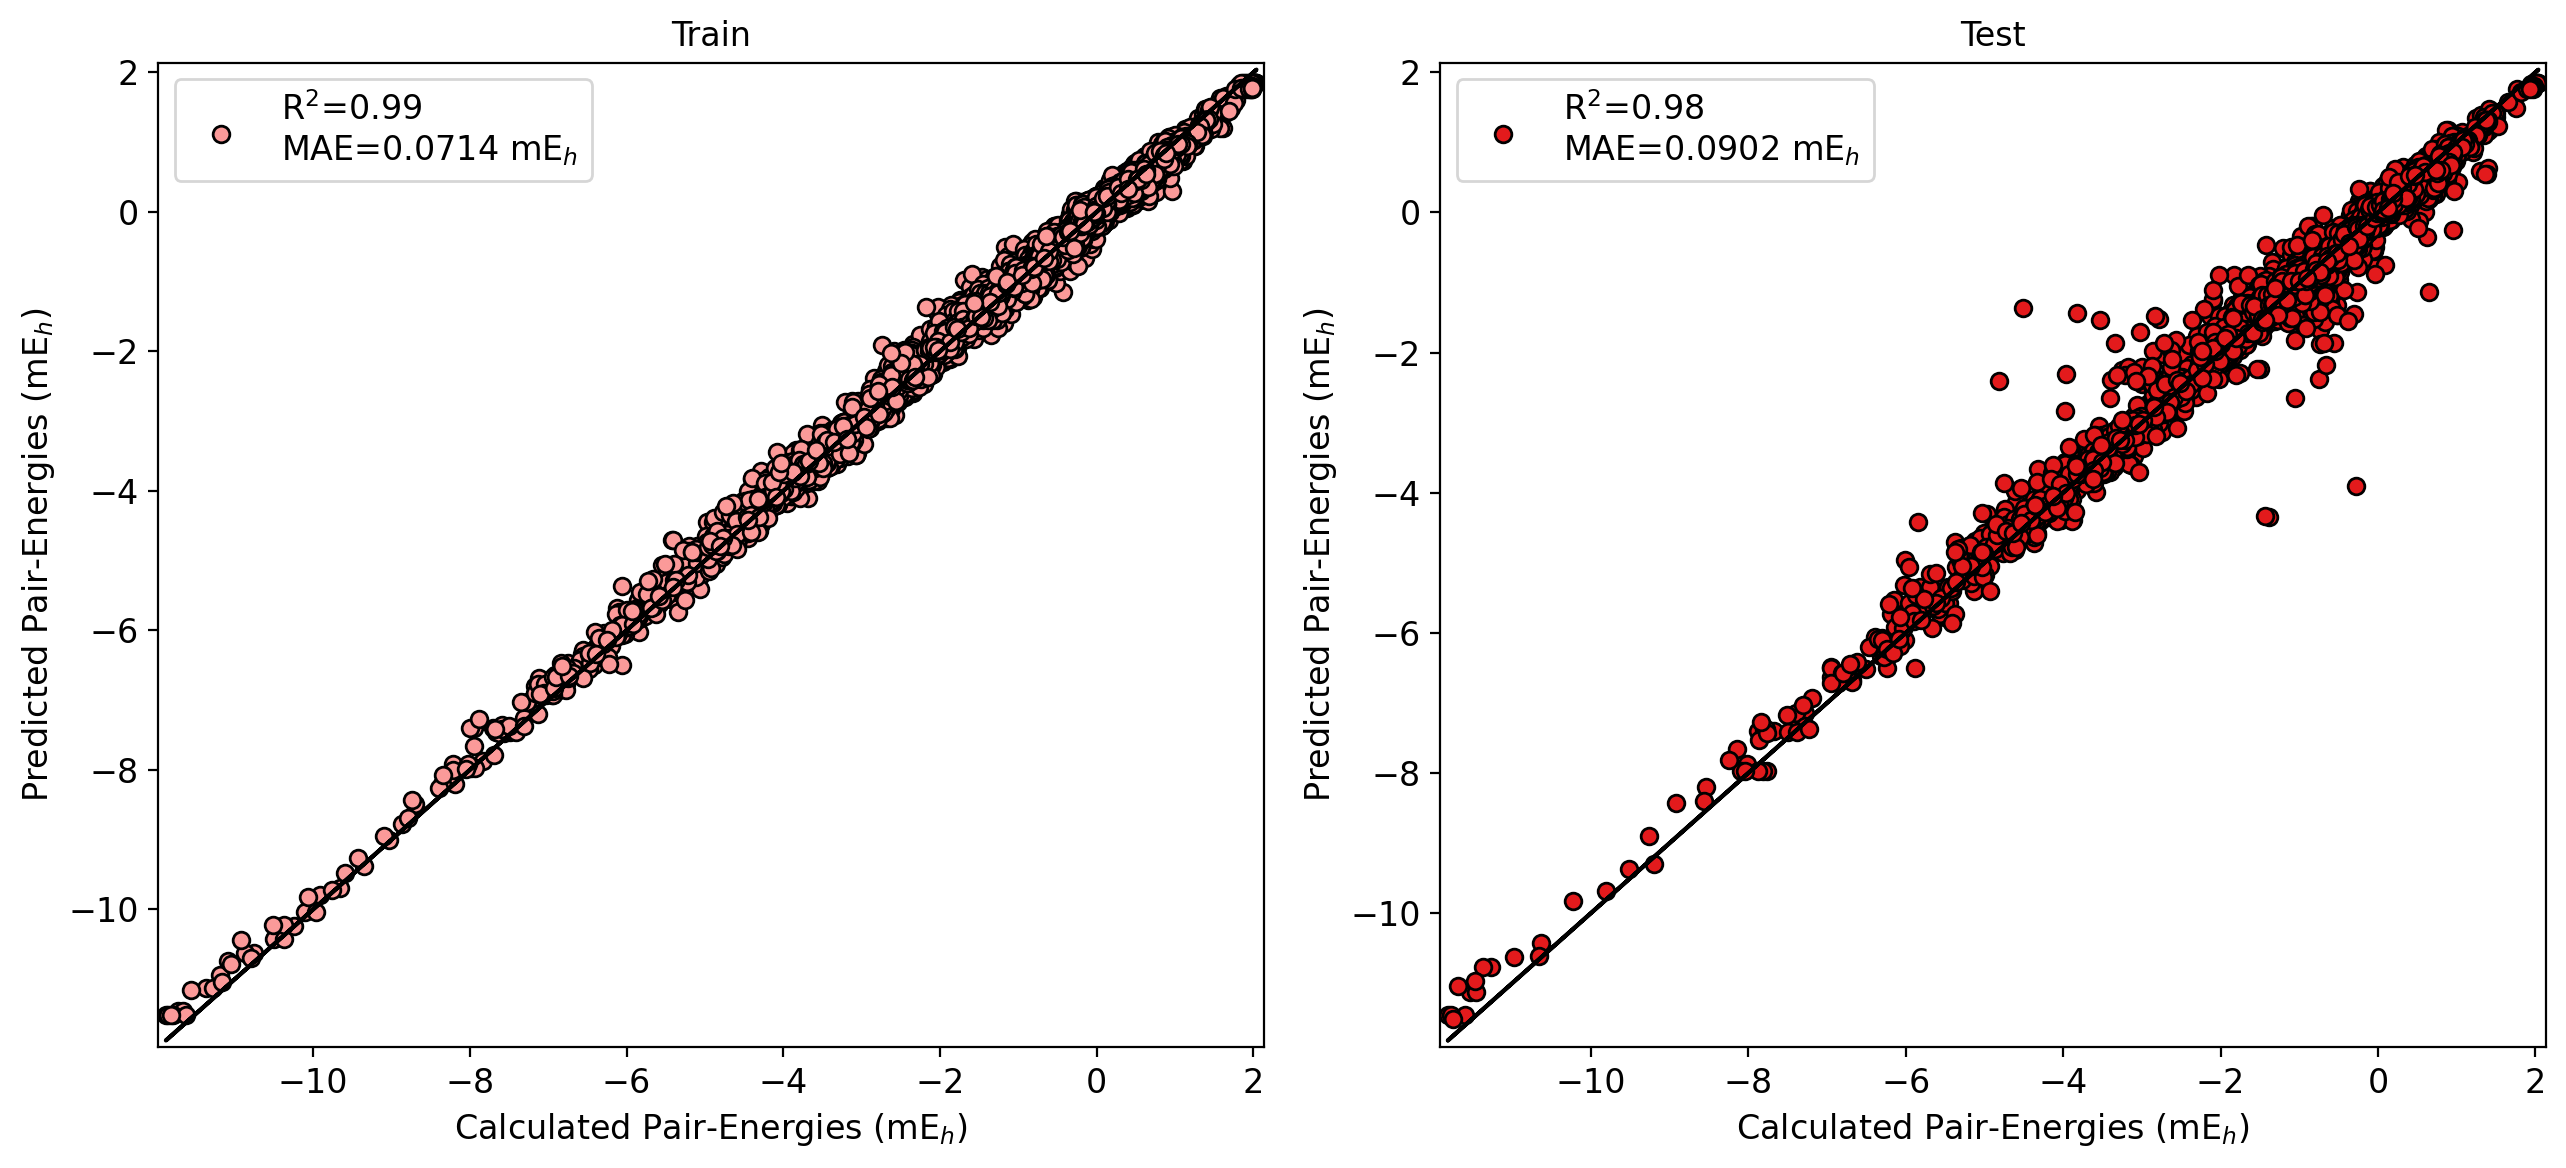

In [14]:
pal = sns.color_palette("Paired")
font=12
plt.rc('font', size=font)          # controls default text sizes
plt.rc('axes', titlesize=font)     # fontsize of the axes title
plt.rc('axes', labelsize=font)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font)    # fontsize of the tick labels
plt.rc('legend', fontsize=font)    # legend fontsize
plt.rc('figure', titlesize=font)  # fontsize of the figure title
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(13,6))
scale=1e-1
ax1.set_title('Train')
ax1.scatter(1e3*y_train,1e3*y_pred_train,label="R$^{2}$="+f'{r2_score(y_train,y_pred_train):.2f}\nMAE={1e3*mean_absolute_error(y_train,y_pred_train):.4f}'+" mE$_{h}$",color=pal[4],edgecolors='k')
ax1.plot(1e3*y_train,1e3*y_train,'k-')
ax1.set_xlim(1e3*min(y_train)-scale,1e3*max(y_train)+scale)
ax1.set_ylim(1e3*min(y_train)-scale,1e3*max(y_train)+scale)
ax1.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax1.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax1.legend()


ax2.set_title('Test')
ax2.scatter(1e3*y_test,1e3*y_pred_test,label="R$^{2}$="+f'{r2_score(y_test,y_pred_test):.2f}\nMAE={1e3*mean_absolute_error(y_test,y_pred_test):.4f}'+" mE$_{h}$",color=pal[5],edgecolors='k')
ax2.plot(1e3*y_test,1e3*y_test,'k-')
ax2.set_xlim(1e3*min(y_test)-scale,1e3*max(y_test)+scale)
ax2.set_ylim(1e3*min(y_test)-scale,1e3*max(y_test)+scale)
ax2.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax2.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax2.legend()

plt.tight_layout()
plt.savefig('images/H2n_parity.png',dpi=300,bbox_inches='tight')
plt.show()

In [15]:
testcntrcvr = 0
recover_test_list = []
recover_test_E2 = []
for i,j,k,l in recover_test:
    init_test = testcntrcvr
    testcntrcvr+=l
    recover_test_list.append((i.split("_")[0],j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
    recover_test_E2.append((i.split("_")[0],j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))


traincntrcvr = 0
recover_train_list = []
recover_train_E2 = []
for i,j,k,l in recover_train:
    init_train = traincntrcvr
    traincntrcvr+=l
    recover_train_list.append((i.split("_")[0],j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
    recover_train_E2.append((i.split("_")[0],j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))

In [16]:
traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:'H$_{2n}$',1:'Radius ($\AA$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
#.astype({'H$_{2n}$':str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:'H$_{2n}$',1:'Radius ($\AA$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
#.astype({'H$_{2n}$':str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})


traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
traincorrE2['E2']=np.zeros(len(traincorrE2))

traincorrE2.index = ["_".join((u,v)) for u,v in traincorrE2[['H$_{2n}$','Radius ($\AA$)']].values]

for i in traincorrE2.index:
    hn, r = i.split('_')
    energy_df = pd.read_excel(f"{hn}_chain/{hn}_{r}/{hn}_{r}_energies.xlsx",index_col=0)
    traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
    traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
    # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values

traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']

traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)


testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
testcorrE2['E2']=np.zeros(len(testcorrE2))

testcorrE2.index = ["_".join((u,v)) for u,v in testcorrE2[['H$_{2n}$','Radius ($\AA$)']].values]

for i in testcorrE2.index:
    hn, r = i.split('_')
    energy_df = pd.read_excel(f"{hn}_chain/{hn}_{r}/{hn}_{r}_energies.xlsx",index_col=0)
    testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
    testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
    # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values

testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']

testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)

In [17]:
traincaspt2melt = traincorrE2.melt(id_vars=['H$_{2n}$','Radius ($\AA$)'], value_vars=['E$_{\text{CASPT2}}^{\text{Calculated}}$','E$_{\text{CASPT2}}^{\text{Predicted}}$']).astype({'Radius ($\AA$)':float,'value':float})
testcaspt2melt = testcorrE2.melt(id_vars=['H$_{2n}$','Radius ($\AA$)'], value_vars=['E$_{\text{CASPT2}}^{\text{Calculated}}$','E$_{\text{CASPT2}}^{\text{Predicted}}$']).astype({'Radius ($\AA$)':float,'value':float})

In [18]:
trueE2=pd.concat([traincorrE2,testcorrE2]).astype({'Radius ($\AA$)':float,'E$_{\text{CASPT2}}^{\text{Calculated}}$':float})

In [19]:
mean_absolute_error(testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(1.0749031665142728)

In [20]:
mean_absolute_error(traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(0.5752539754040886)

In [21]:
pairedcp=sns.color_palette('Paired')

In [22]:
try:
    os.mkdir('images')
except:
    print("./images exists")

./images exists


In [23]:
traincorrE2.max()

H$_{2n}$                                         H8
Radius ($\AA$)                                 2.98
E$_{2}^{\text{Calculated}}$               -0.000112
E$_{2}^{\text{Predicted}}$                -0.000069
E$_{\text{CASPT2}}^{\text{Calculated}}$   -0.996947
E$_{\text{CASSCF}}^{\text{Calculated}}$   -0.996835
E2                                              0.0
E$_{\text{CASPT2}}^{\text{Predicted}}$    -0.997043
dtype: object

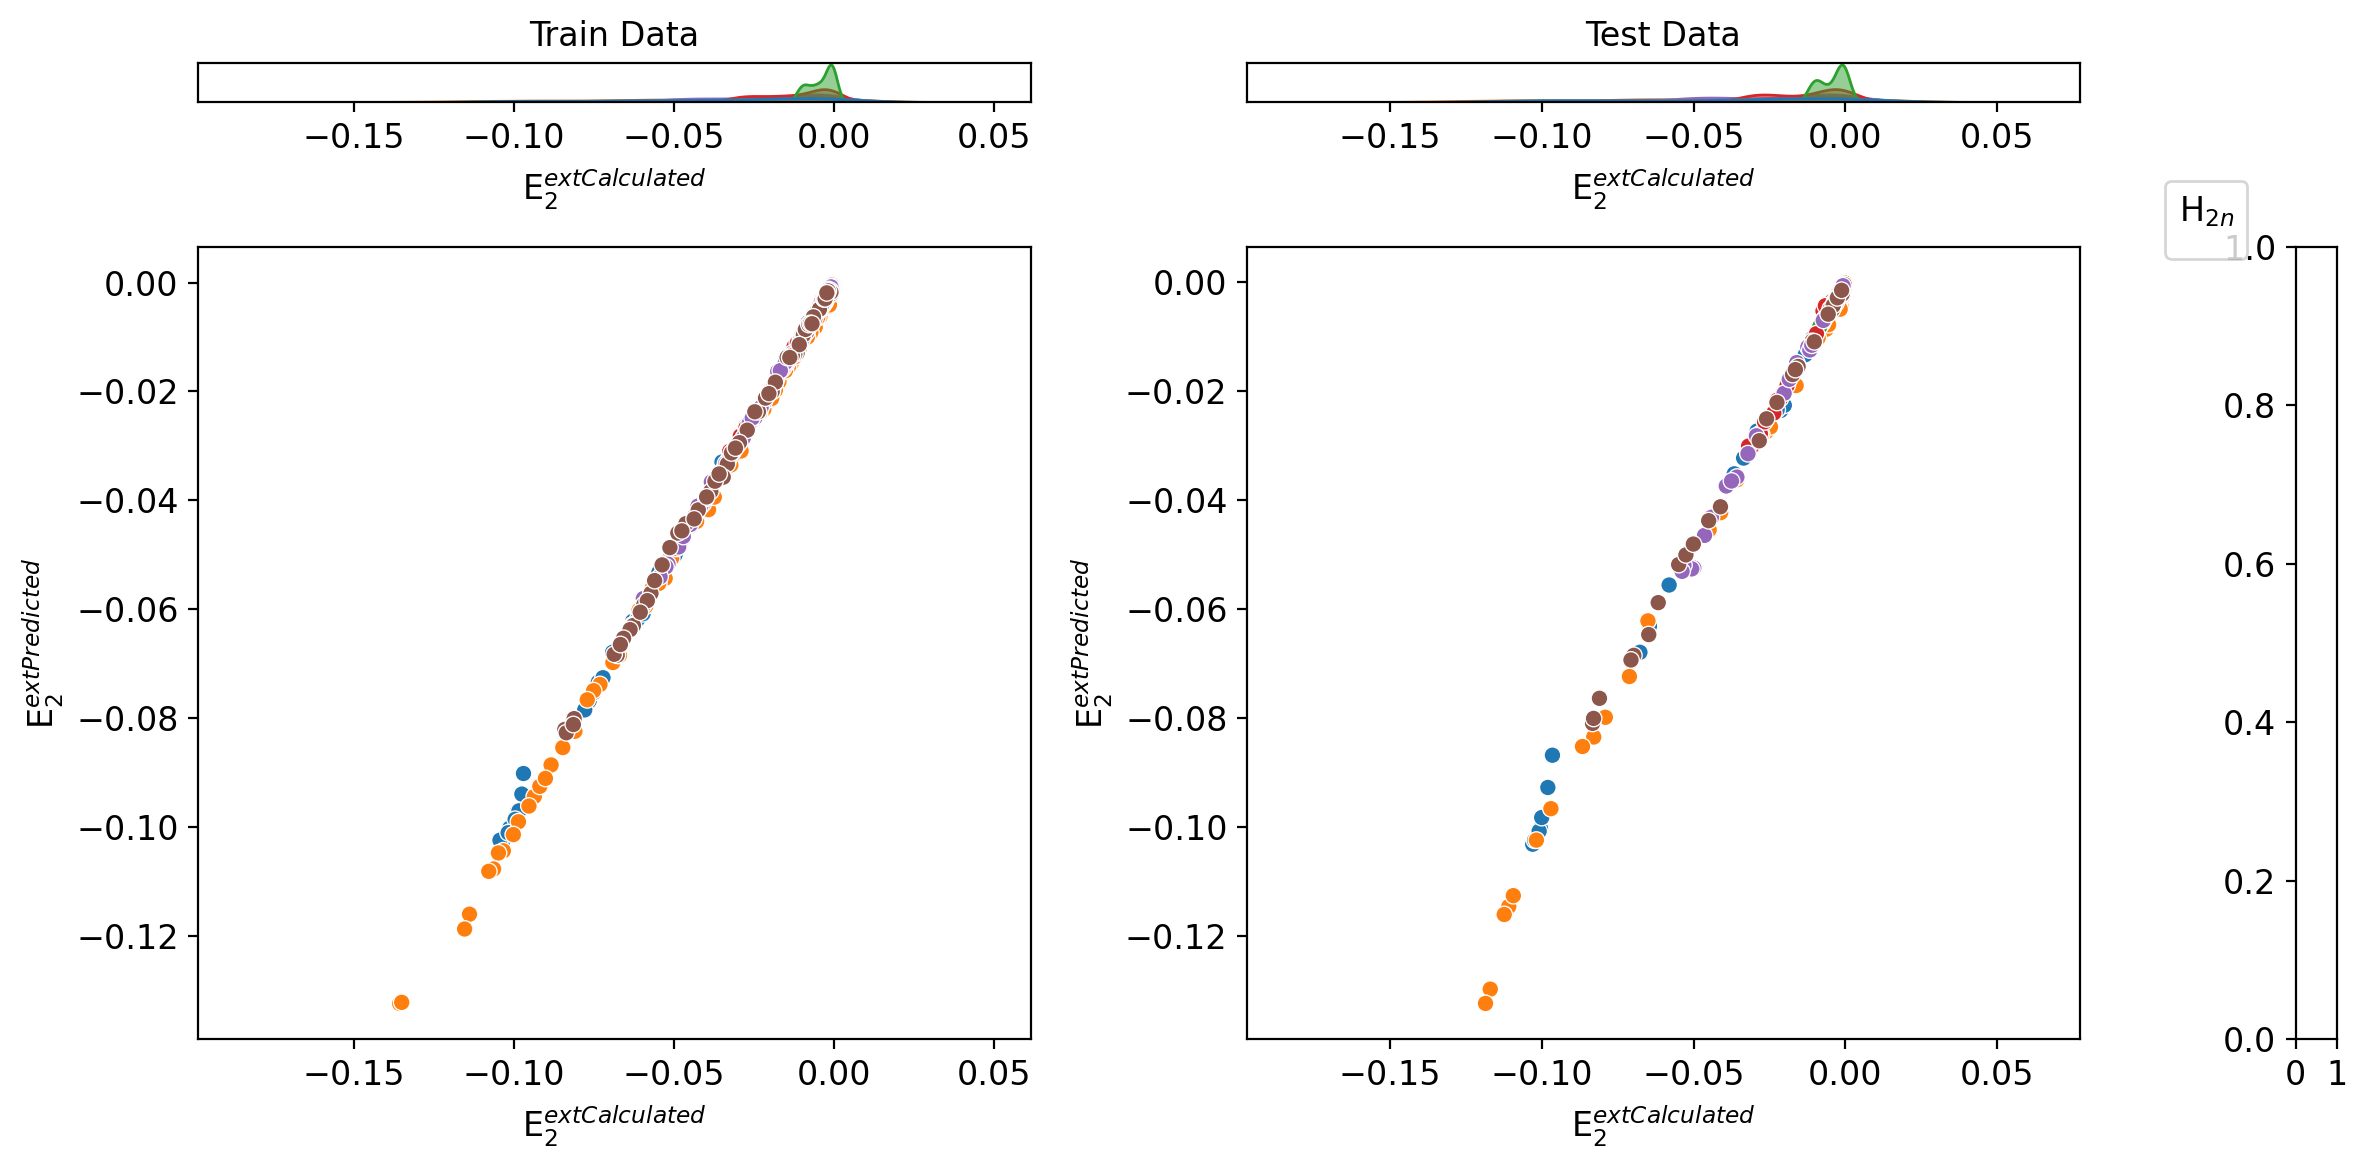

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, width_ratios=[4, 4, 0.2], height_ratios=[0.2, 4], figure=fig)

# Main scatter plot axes
ax_scatter1 = fig.add_subplot(gs[1, 0])
ax_scatter2 = fig.add_subplot(gs[1, 1])

# KDE axes for Calculated values
ax_kde1 = fig.add_subplot(gs[0, 0], sharex=ax_scatter1)
ax_kde2 = fig.add_subplot(gs[0, 1], sharex=ax_scatter2)

# Colorbar axis
cbar_ax = fig.add_subplot(gs[1, 2])

# Train data scatter plot
scatter1 = sns.scatterplot(
    data=traincorrE2, 
    x='E$_{2}^{\text{Calculated}}$', 
    y='E$_{2}^{\text{Predicted}}$', 
    hue='H$_{2n}$', 
    ax=ax_scatter1, 
    legend=False
)

# Test data scatter plot
scatter2 = sns.scatterplot(
    data=testcorrE2, 
    x='E$_{2}^{\text{Calculated}}$', 
    y='E$_{2}^{\text{Predicted}}$', 
    hue='H$_{2n}$', 
    ax=ax_scatter2, 
    legend=False
)

# Train data KDE plot for Calculated values
sns.kdeplot(
    data=traincorrE2, 
    x='E$_{2}^{\text{Calculated}}$', 
    hue='H$_{2n}$', 
    ax=ax_kde1, 
    fill=True, 
    alpha=0.5, 
    legend=False
)

# Test data KDE plot for Calculated values
sns.kdeplot(
    data=testcorrE2, 
    x='E$_{2}^{\text{Calculated}}$', 
    hue='H$_{2n}$', 
    ax=ax_kde2, 
    fill=True, 
    alpha=0.5, 
    legend=False
)

# Adjust labels and titles
ax_kde1.set_title("Train Data")
ax_kde2.set_title("Test Data")
ax_kde1.set_ylabel("")  # Remove unnecessary ylabel
ax_kde2.set_ylabel("")
ax_kde1.tick_params(axis='y', left=False, labelleft=False)  # Remove y-ticks
ax_kde2.tick_params(axis='y', left=False, labelleft=False)

# Add a single legend
handles, labels = scatter2.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", title="H$_{2n}$", bbox_to_anchor=(0.95, 0.85))

# Tight layout and show
plt.tight_layout()
plt.show()


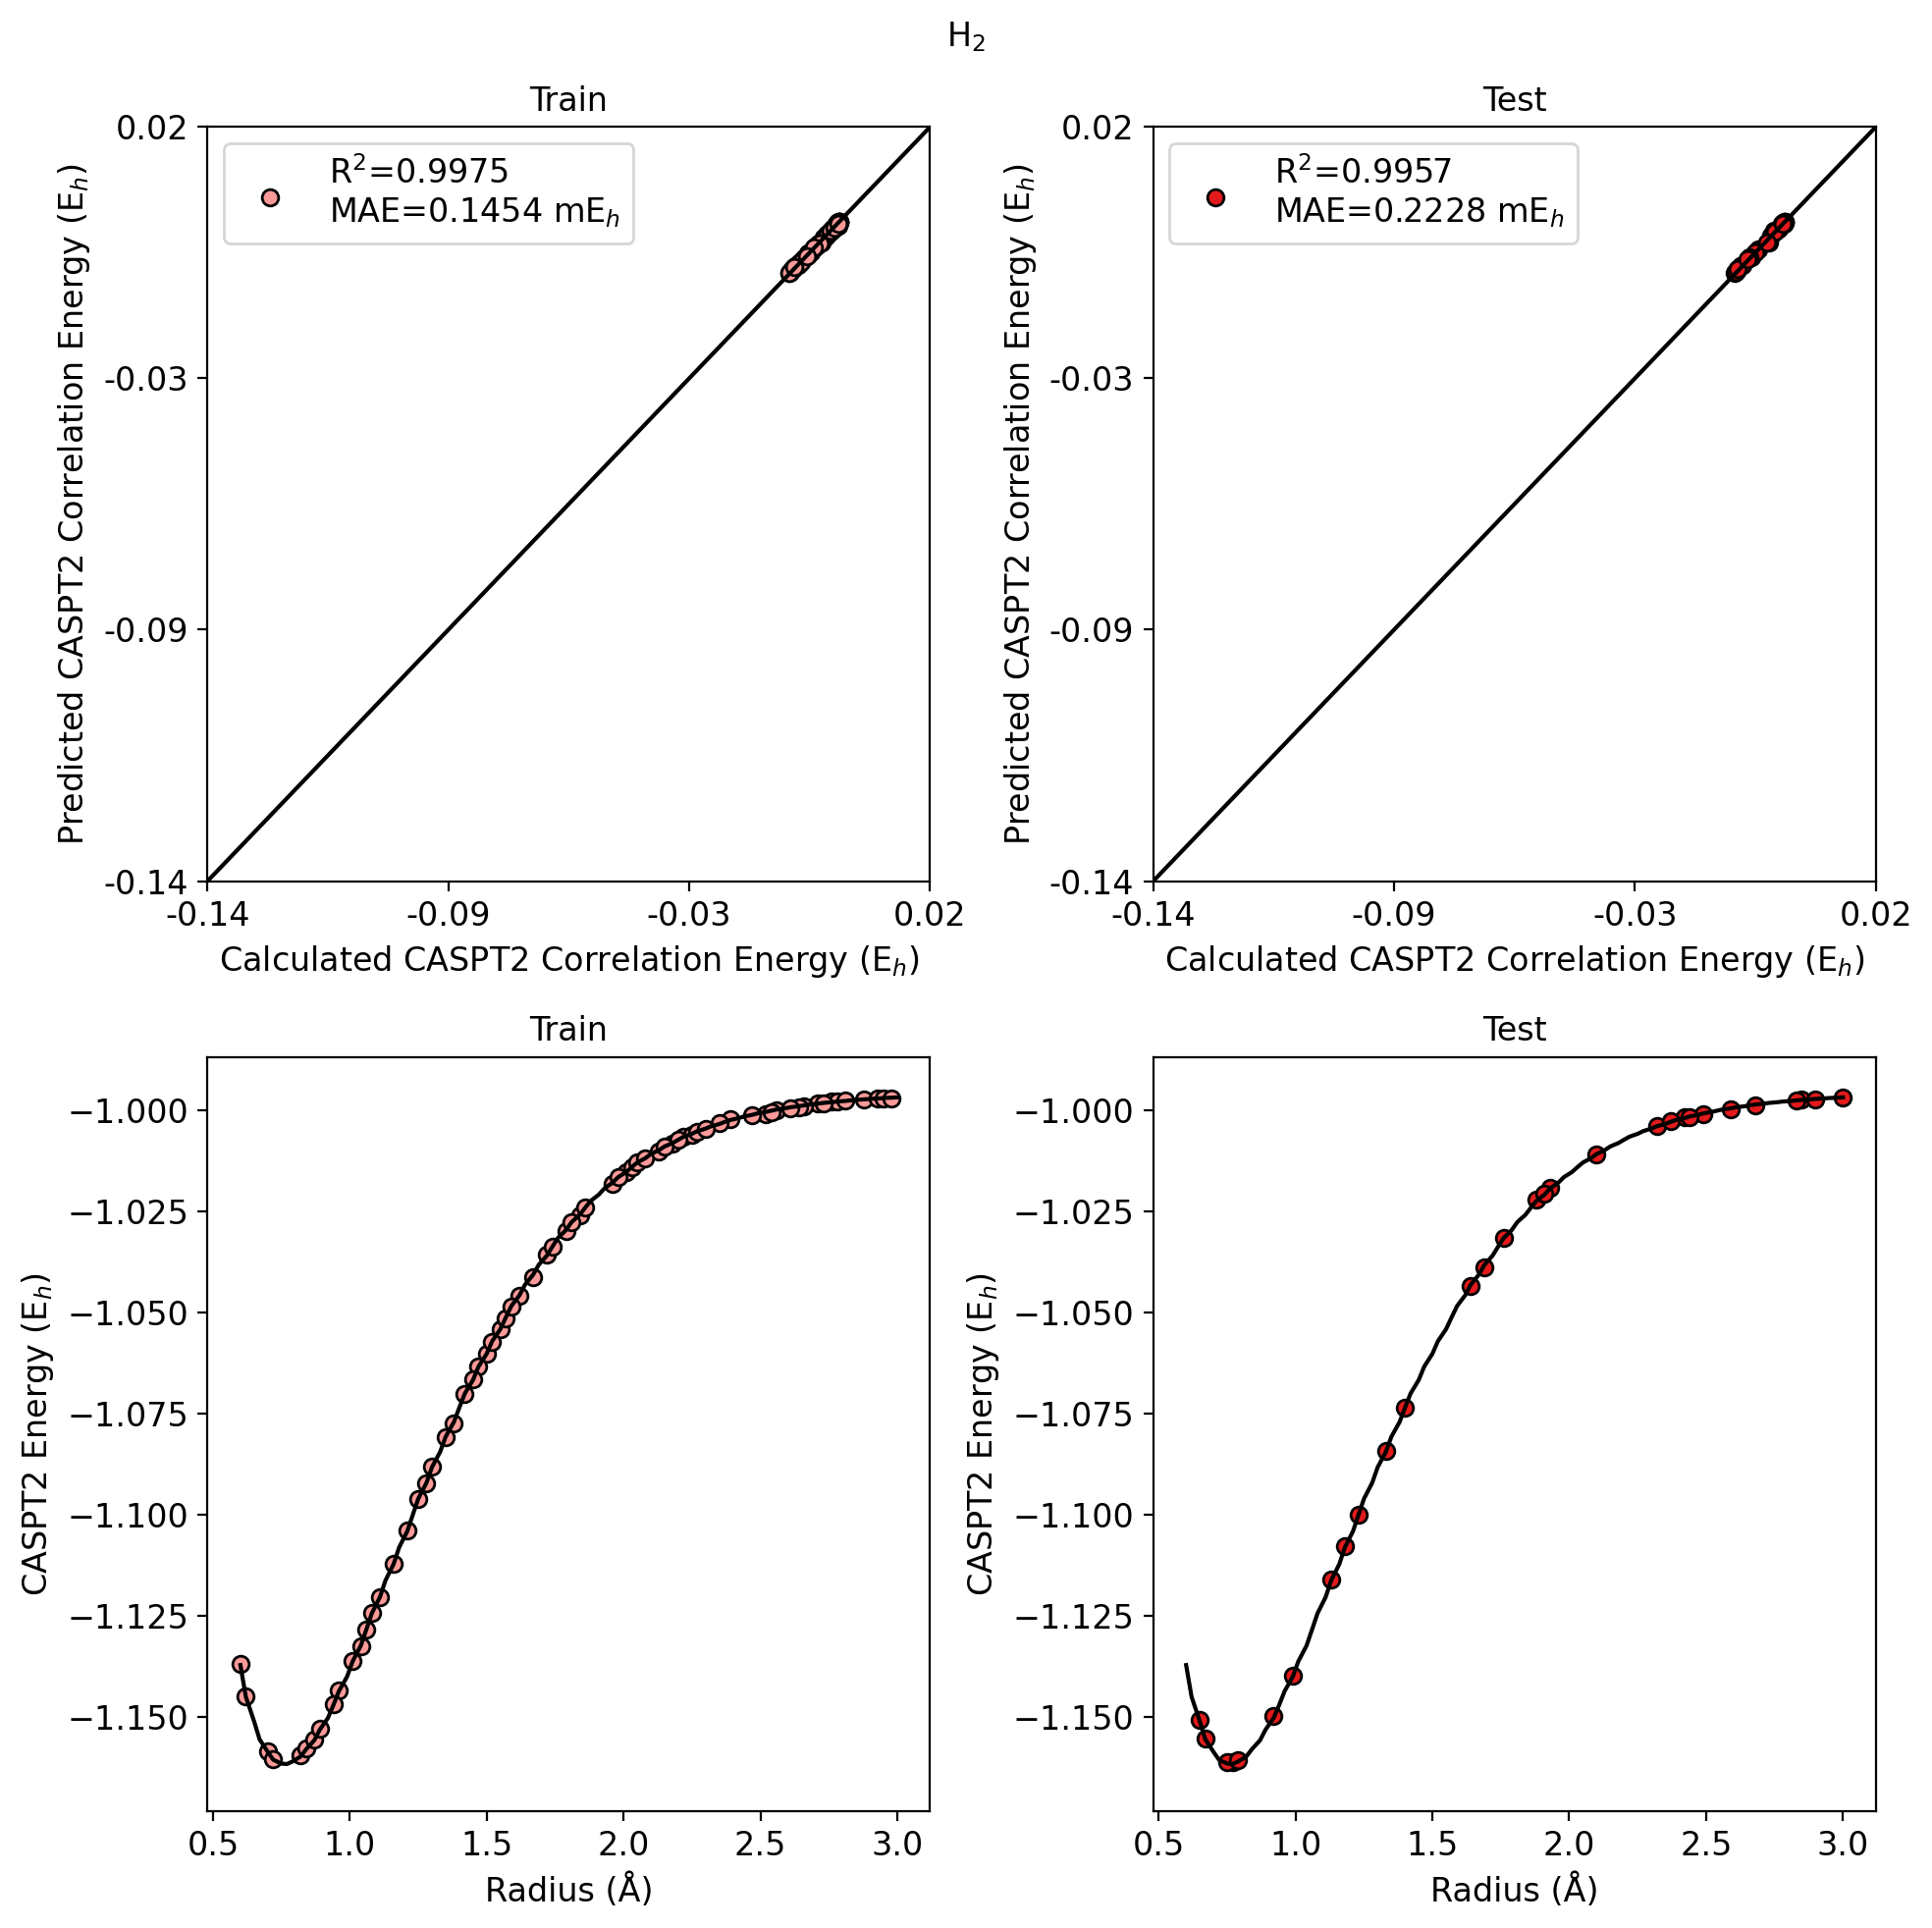

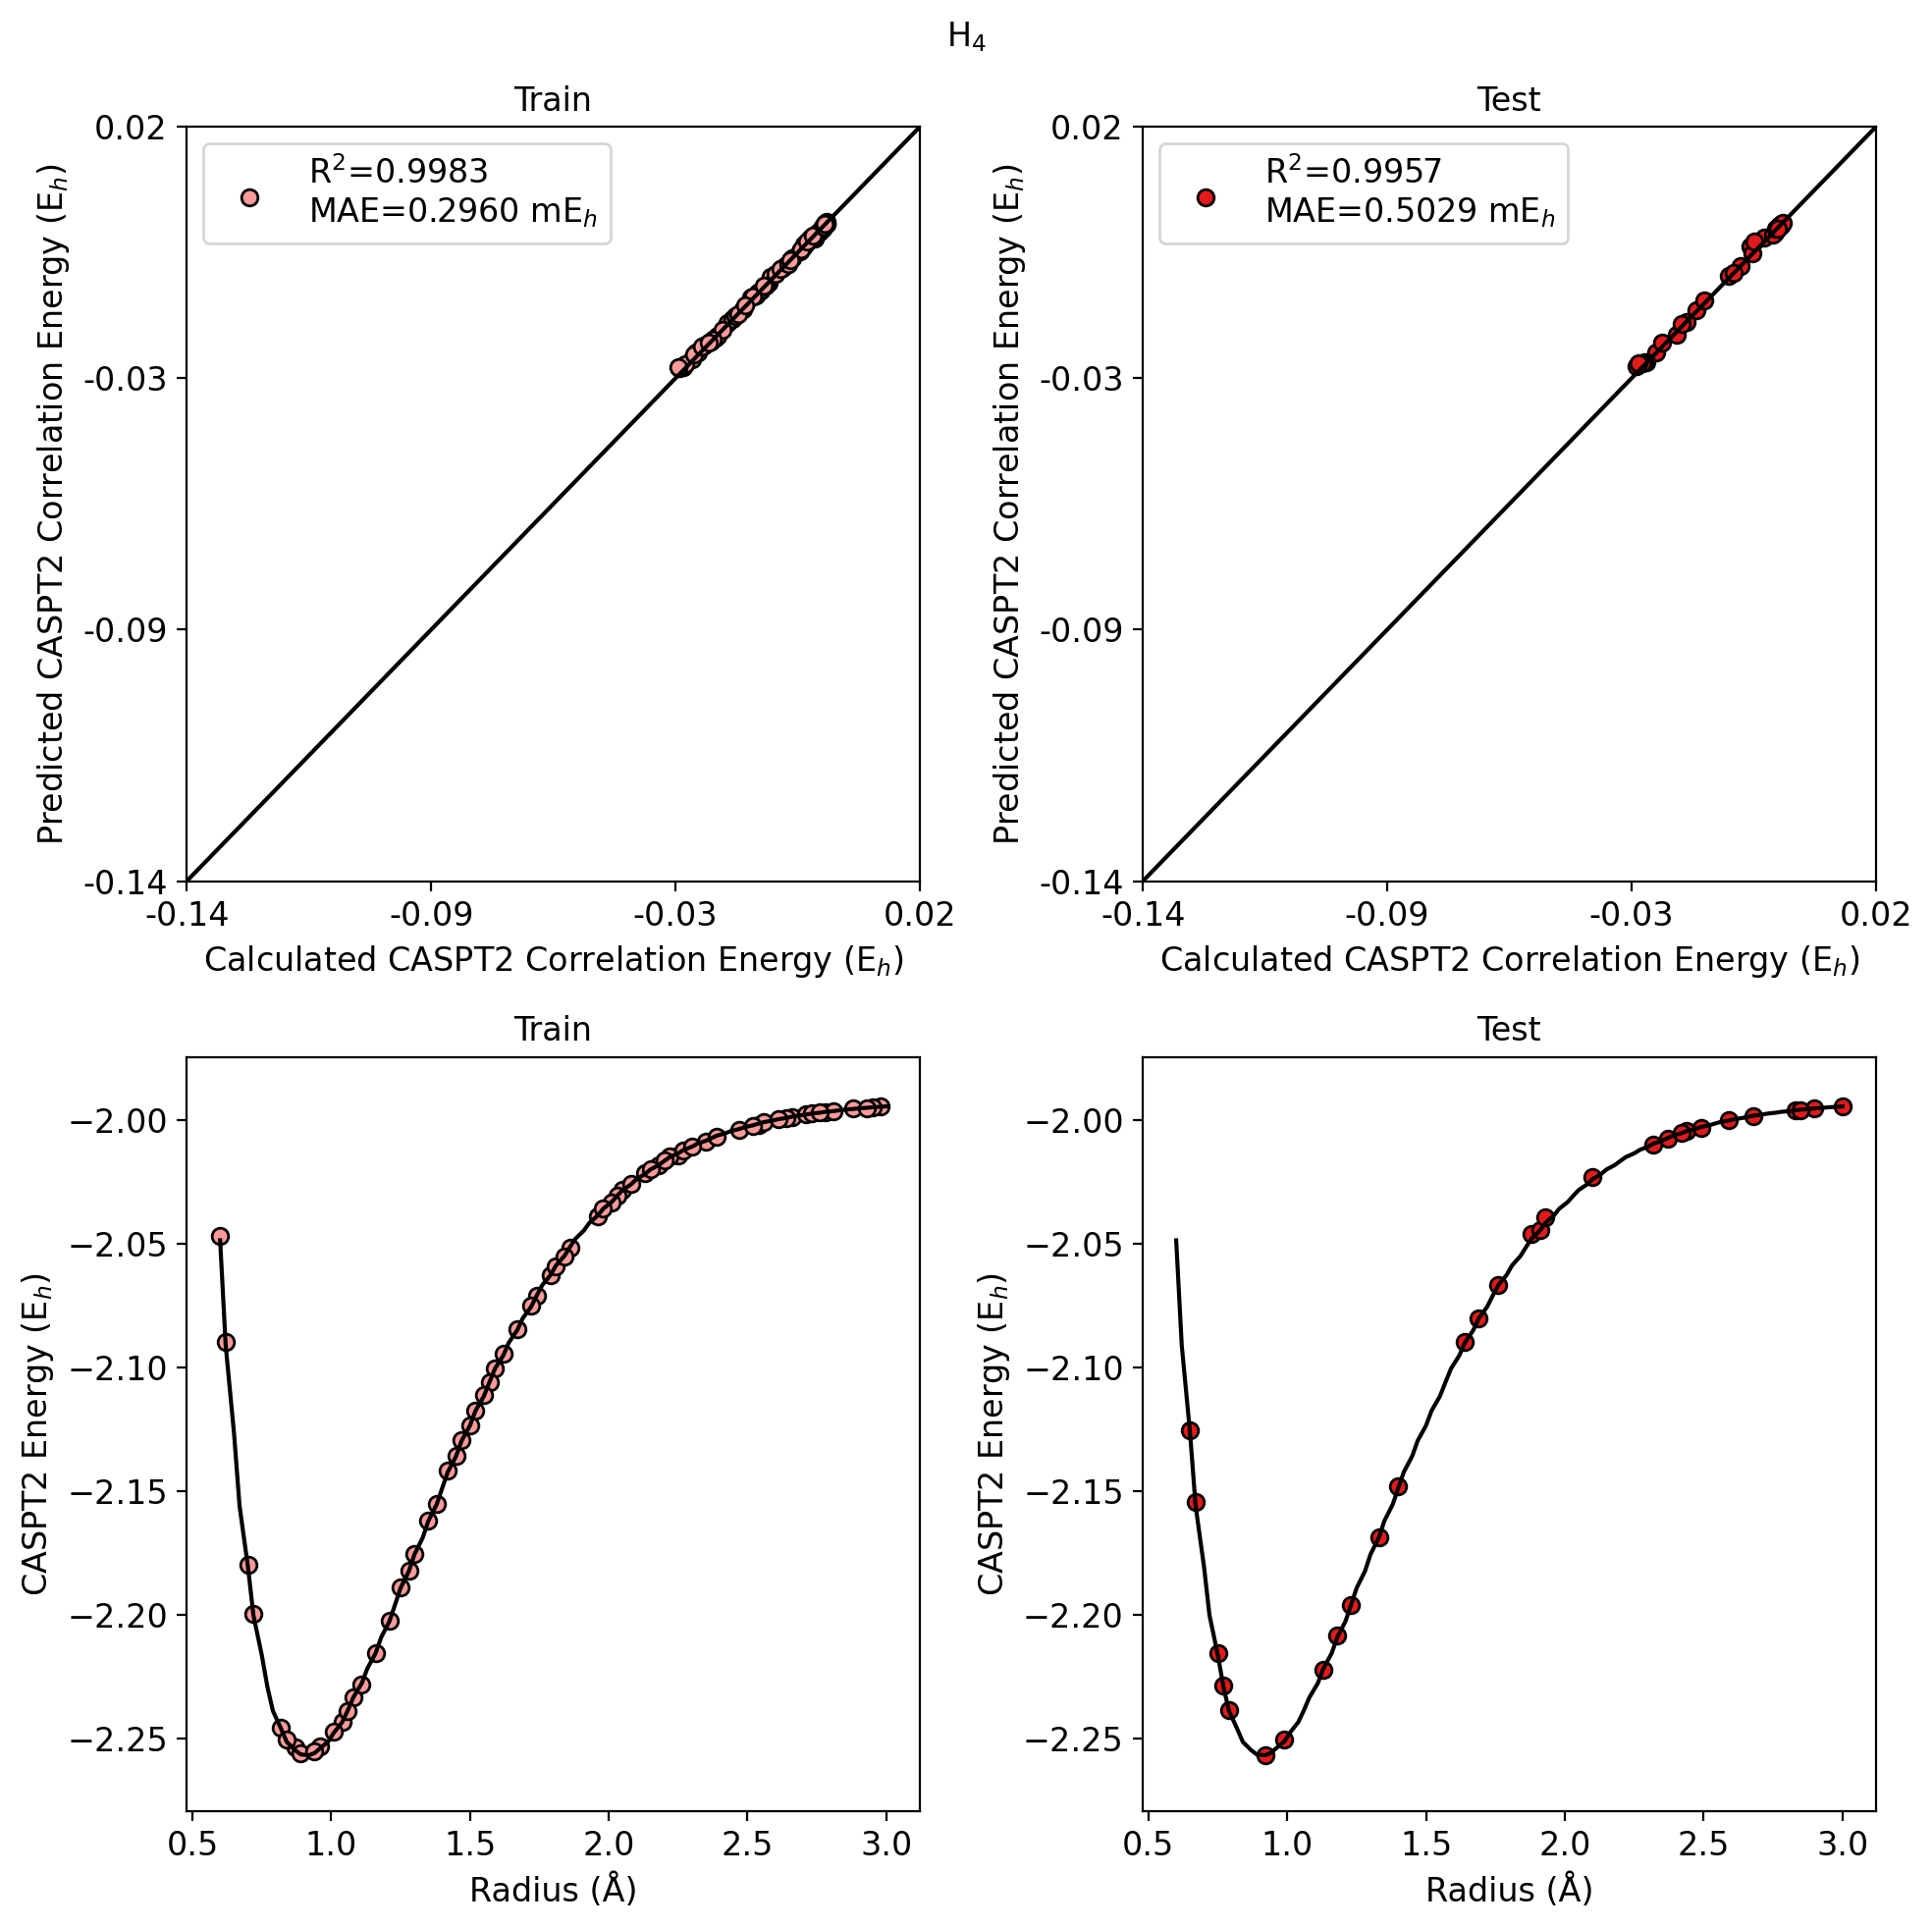

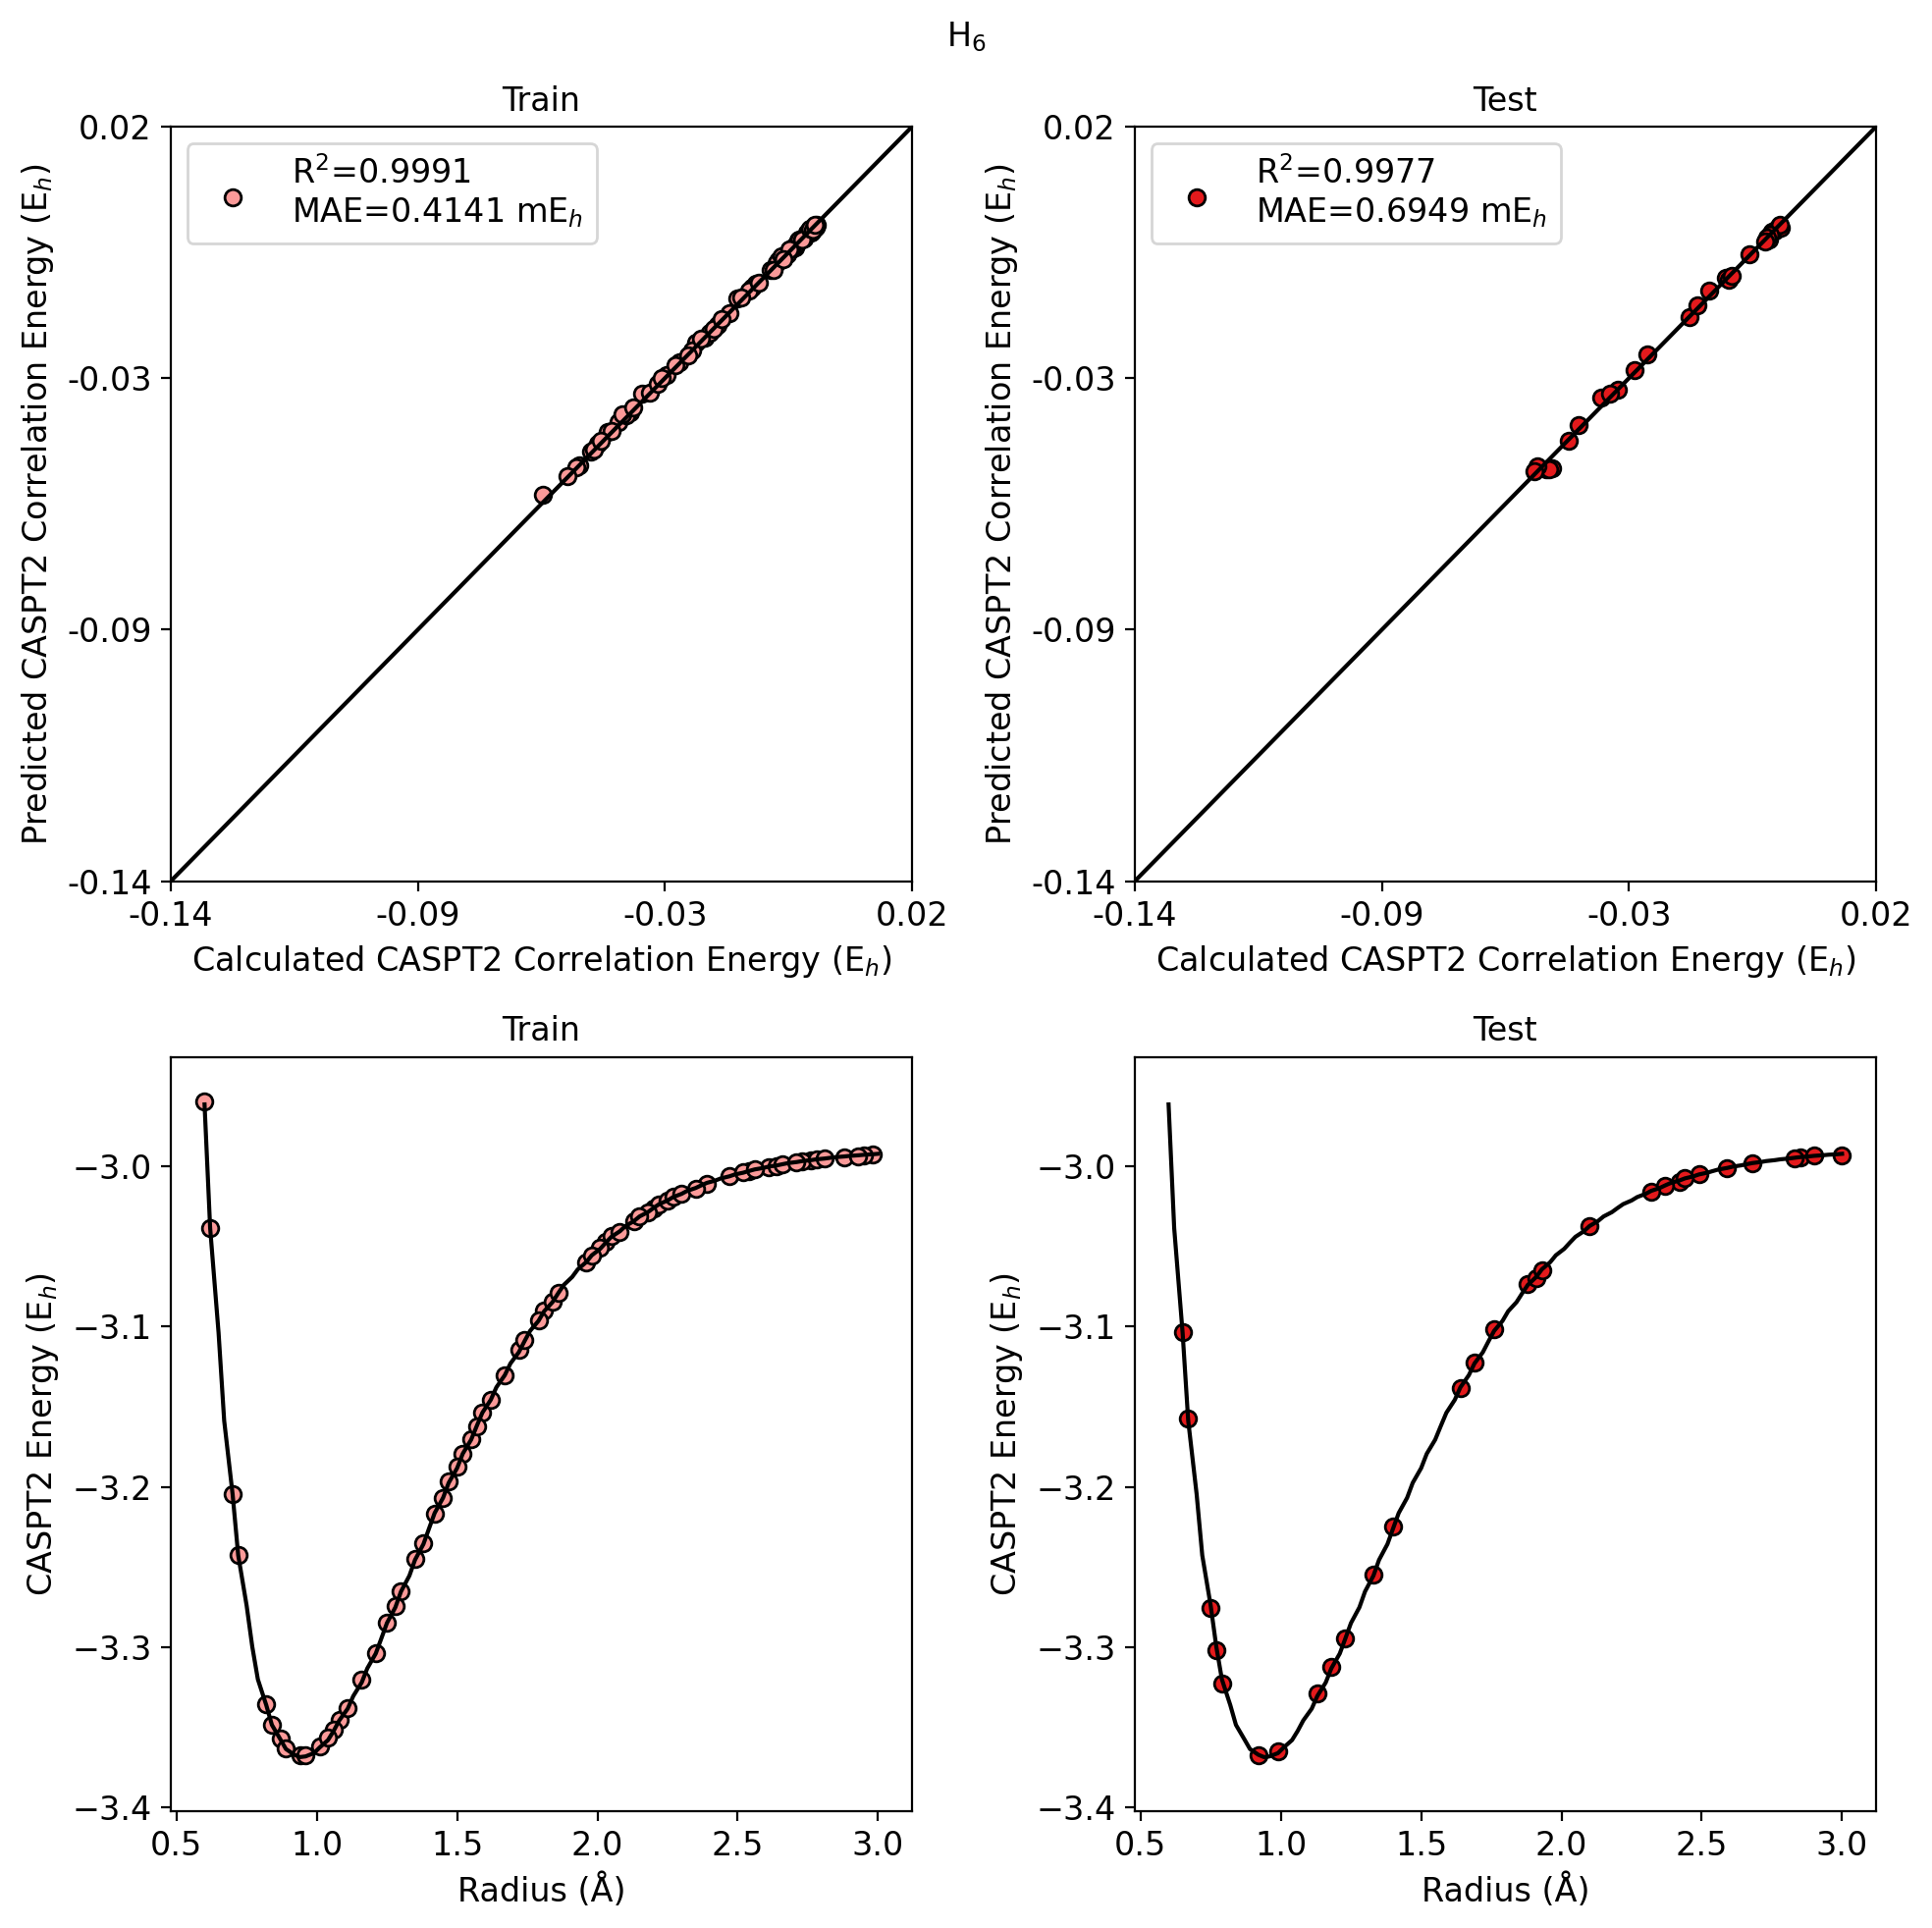

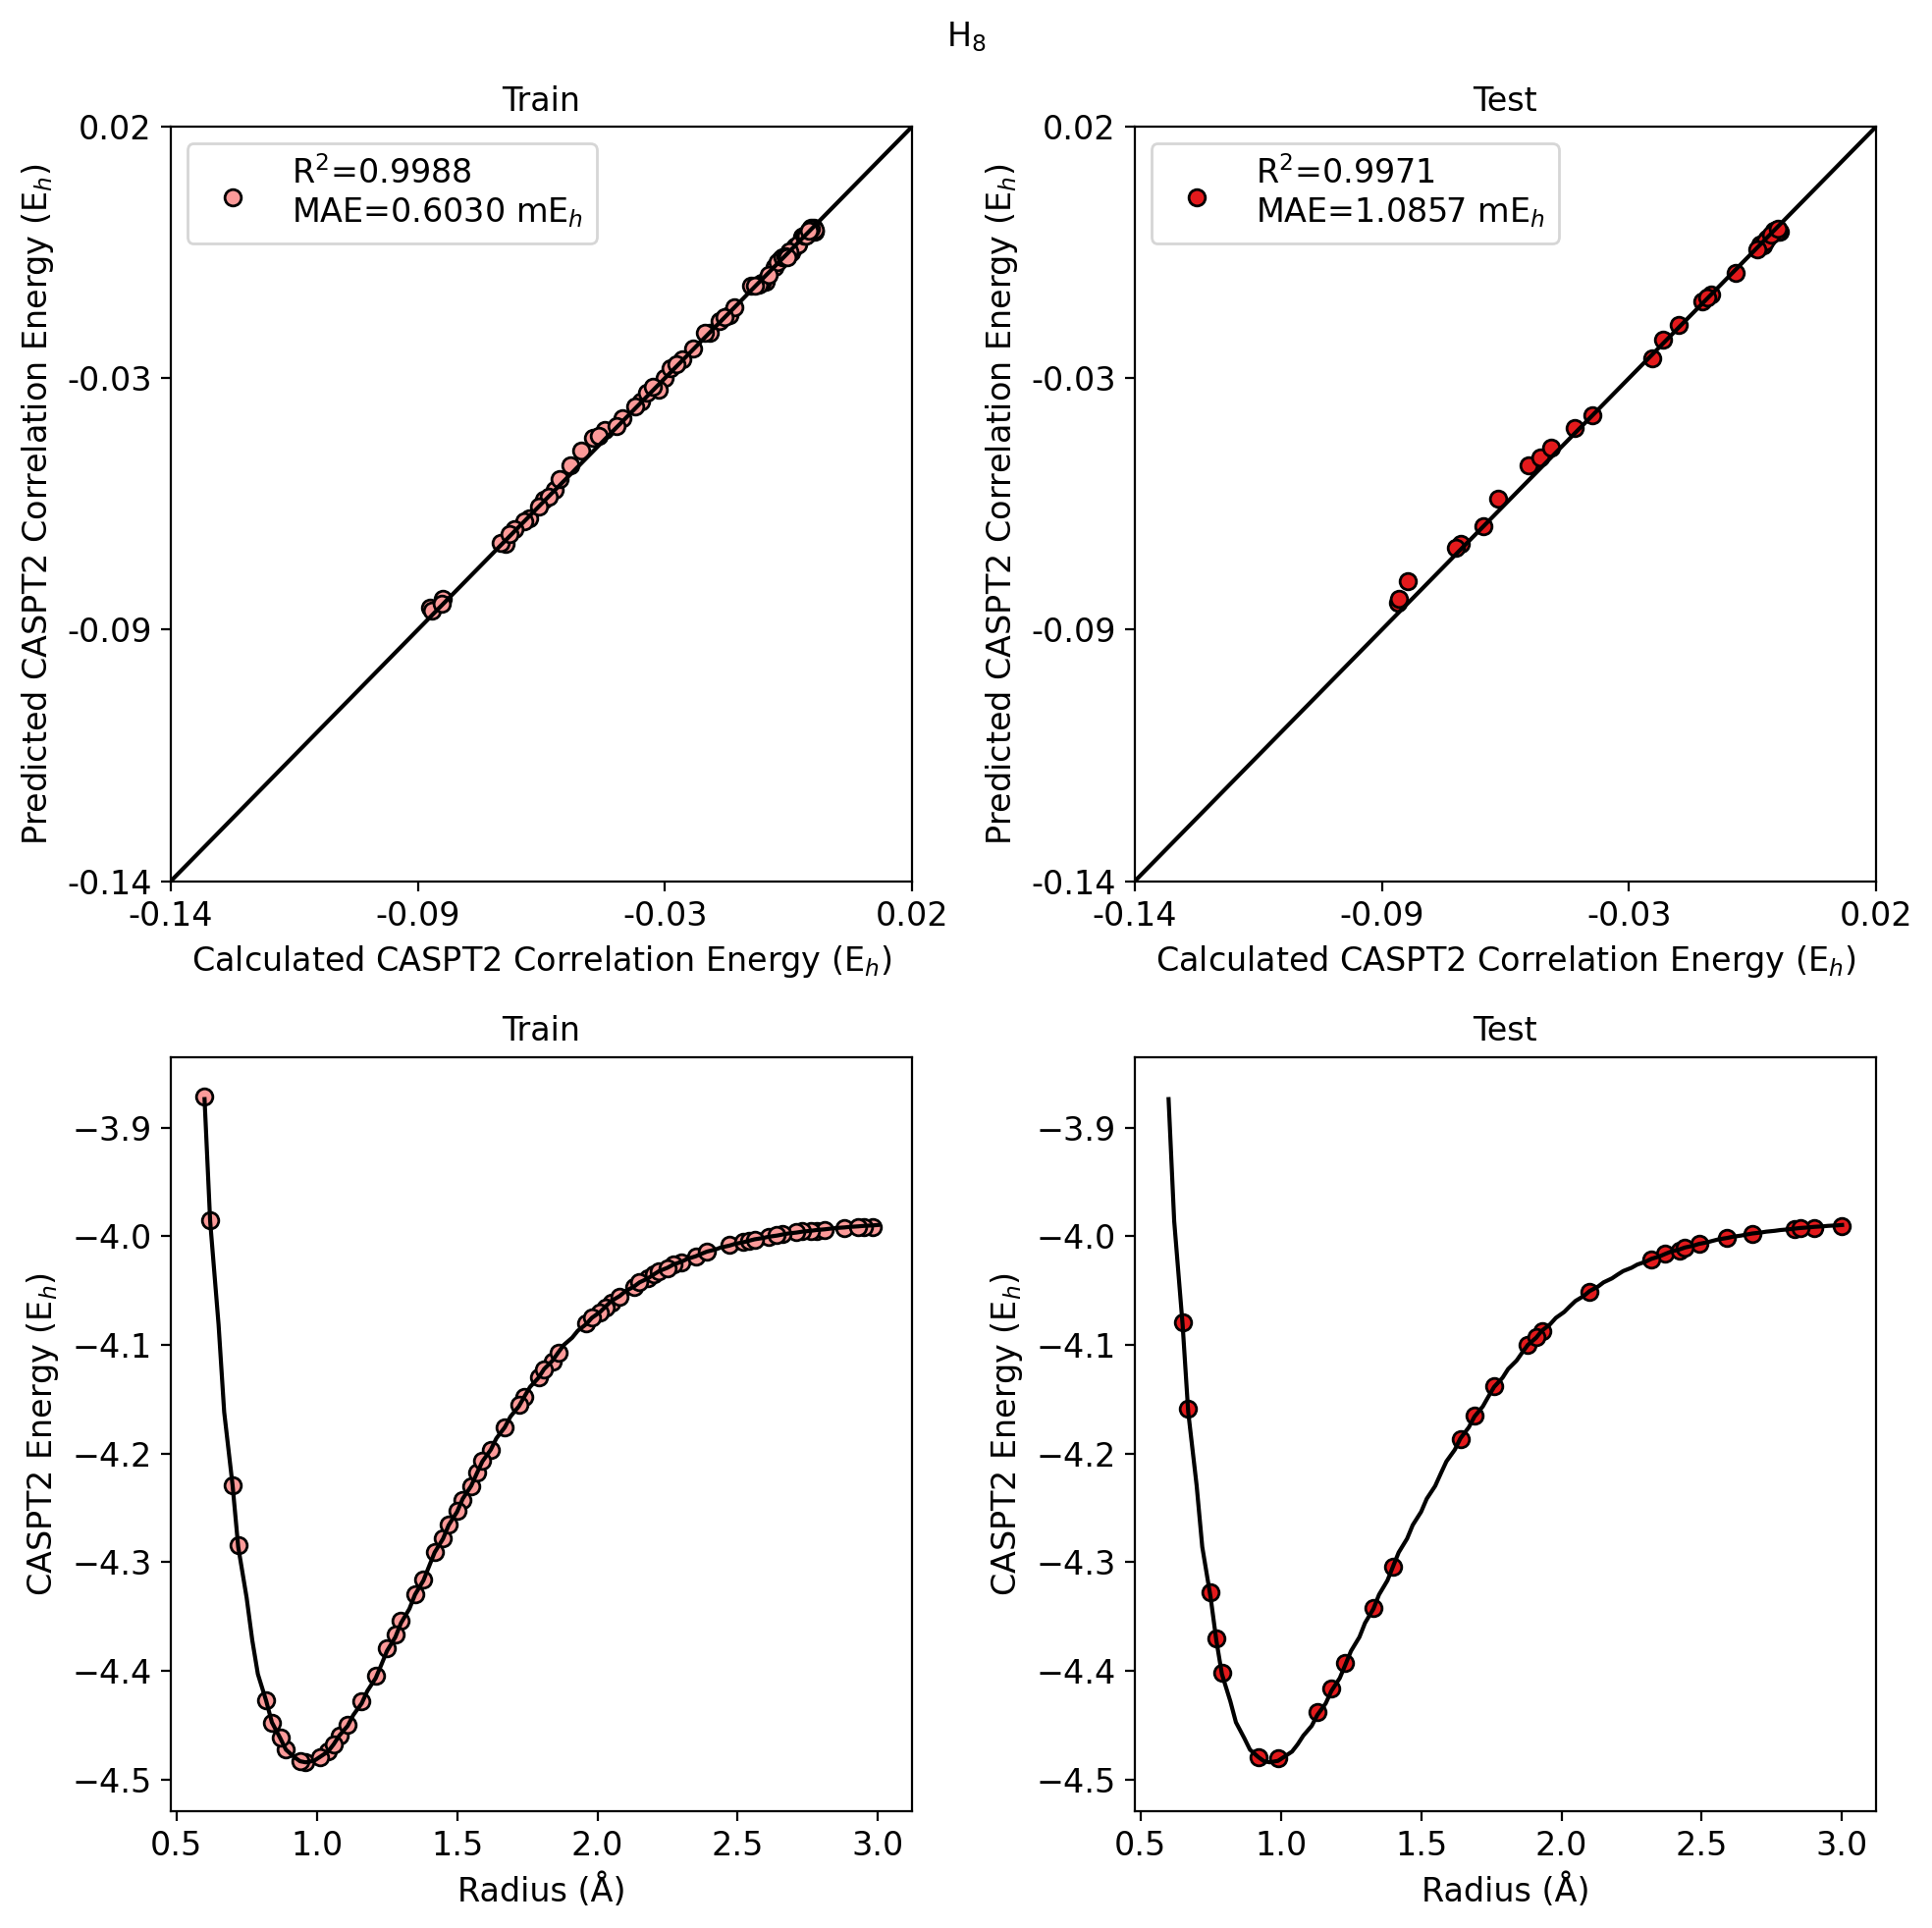

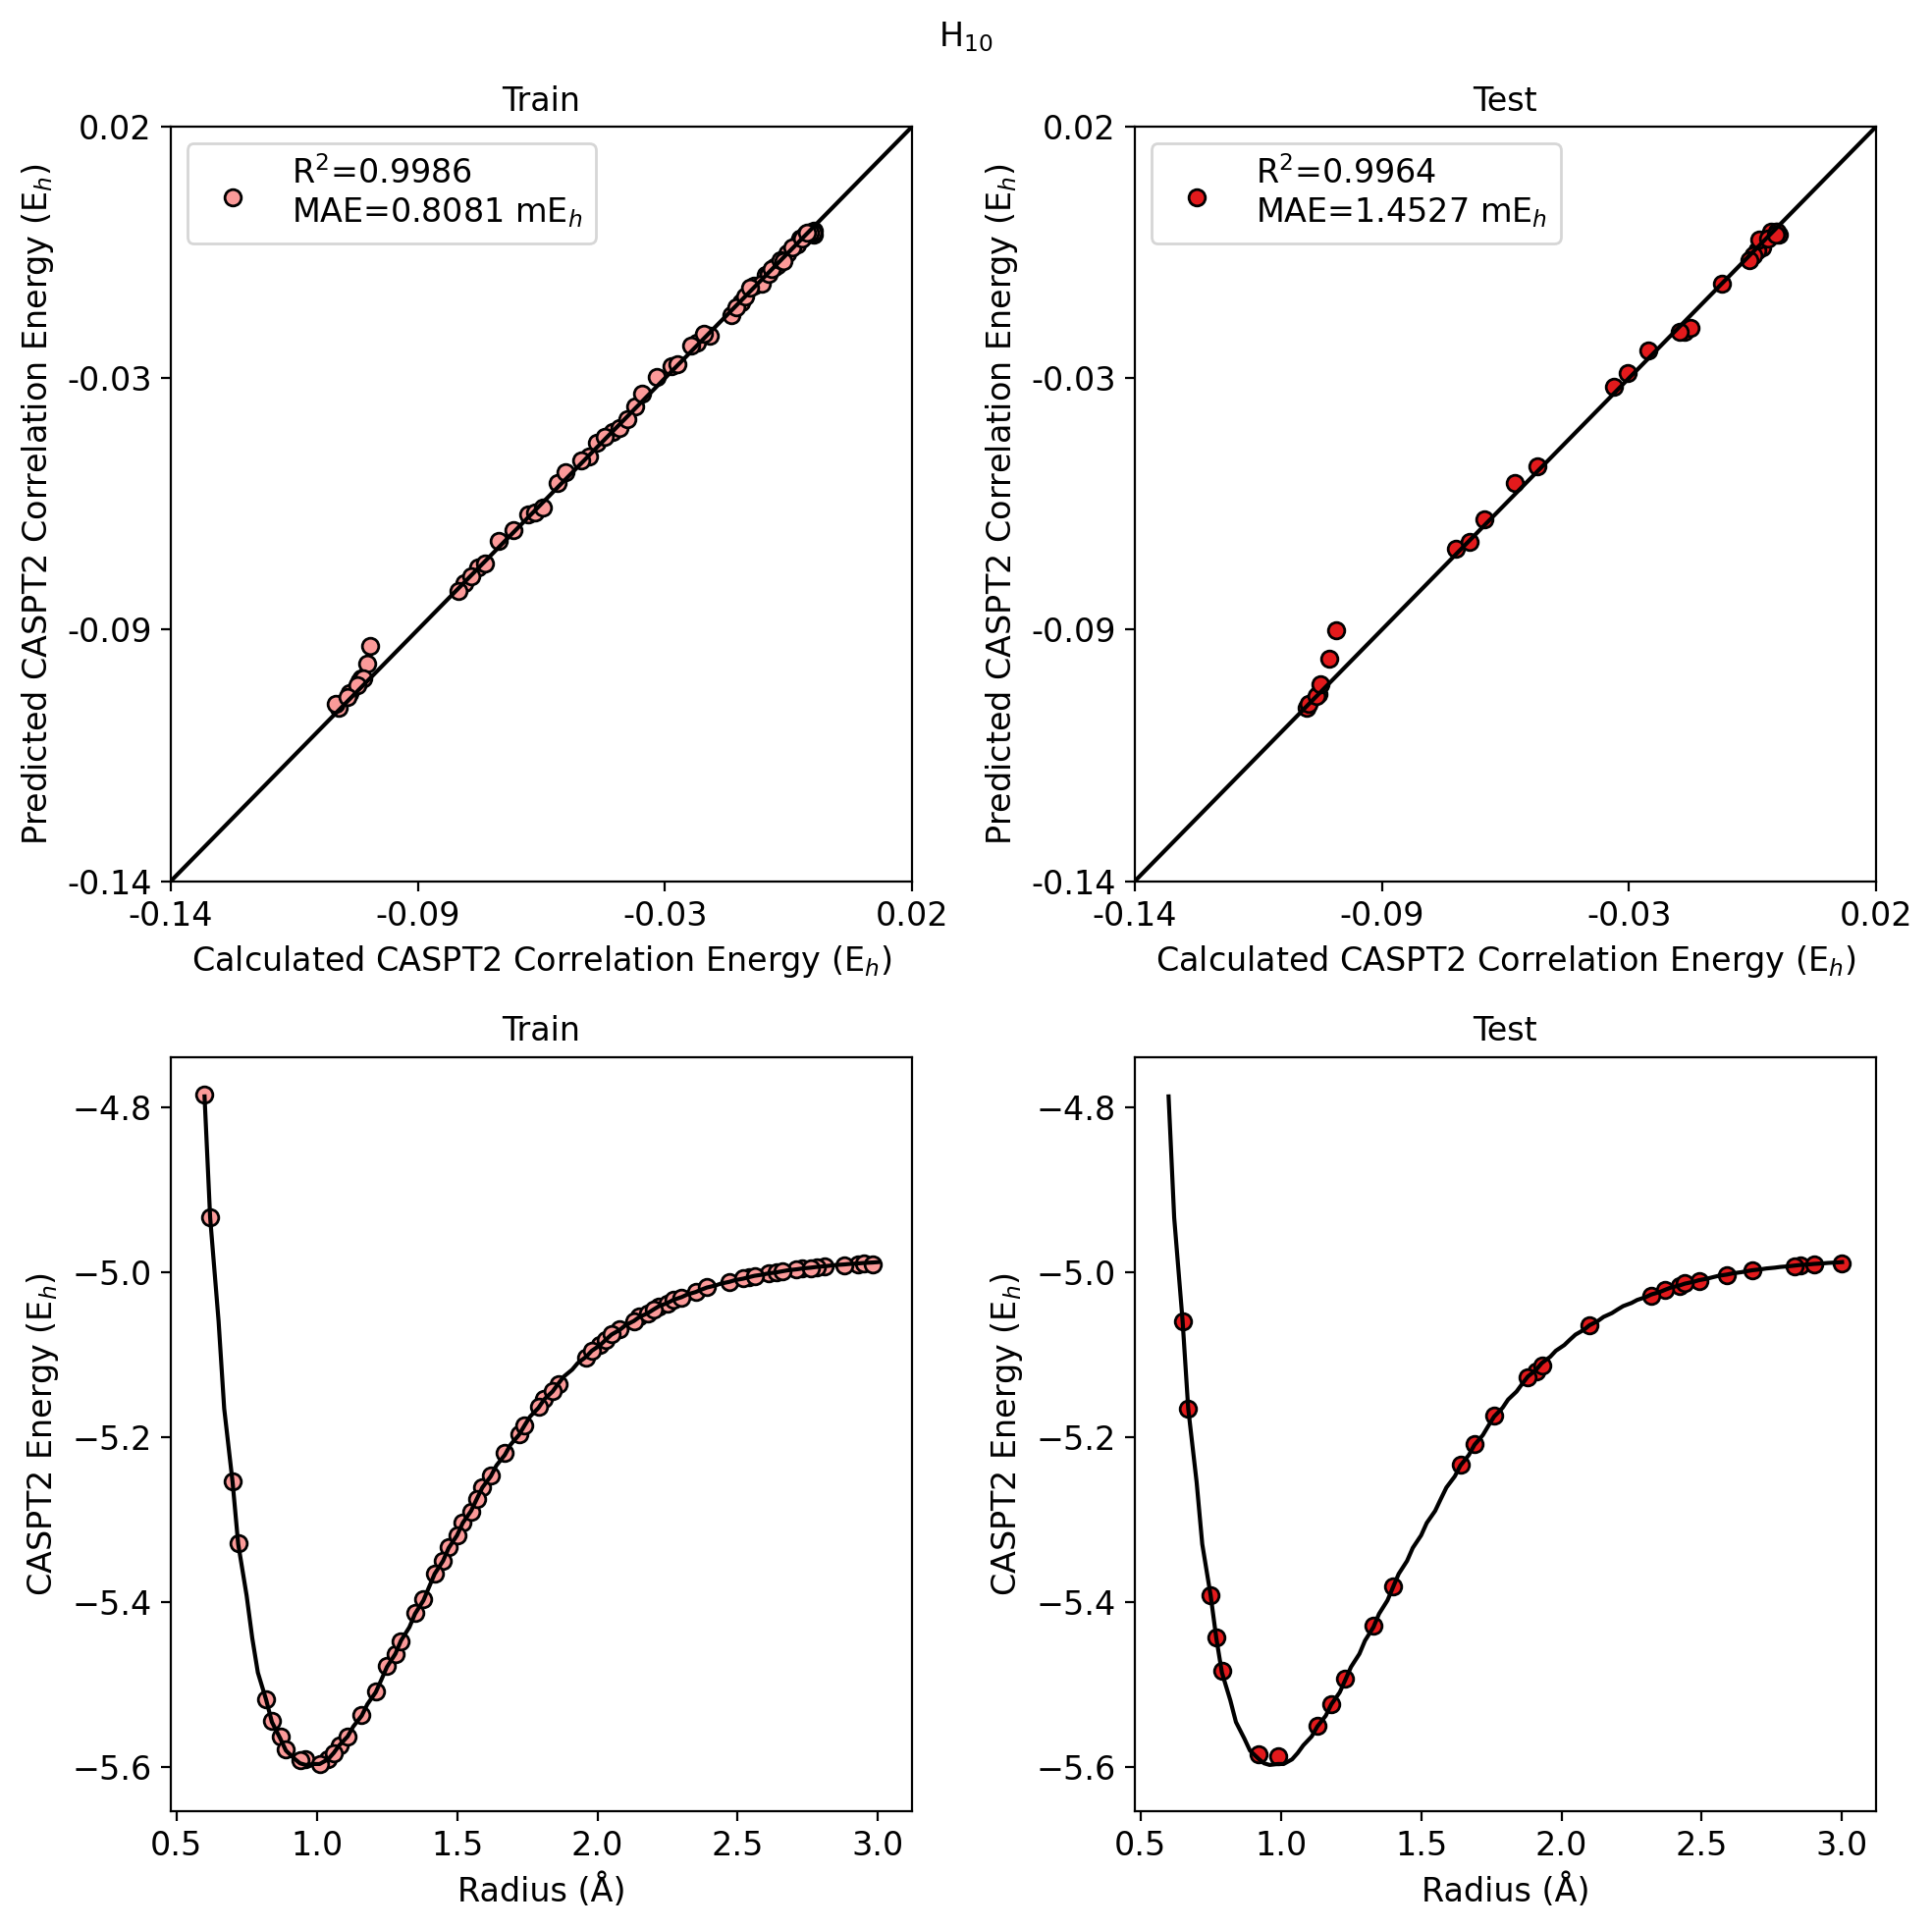

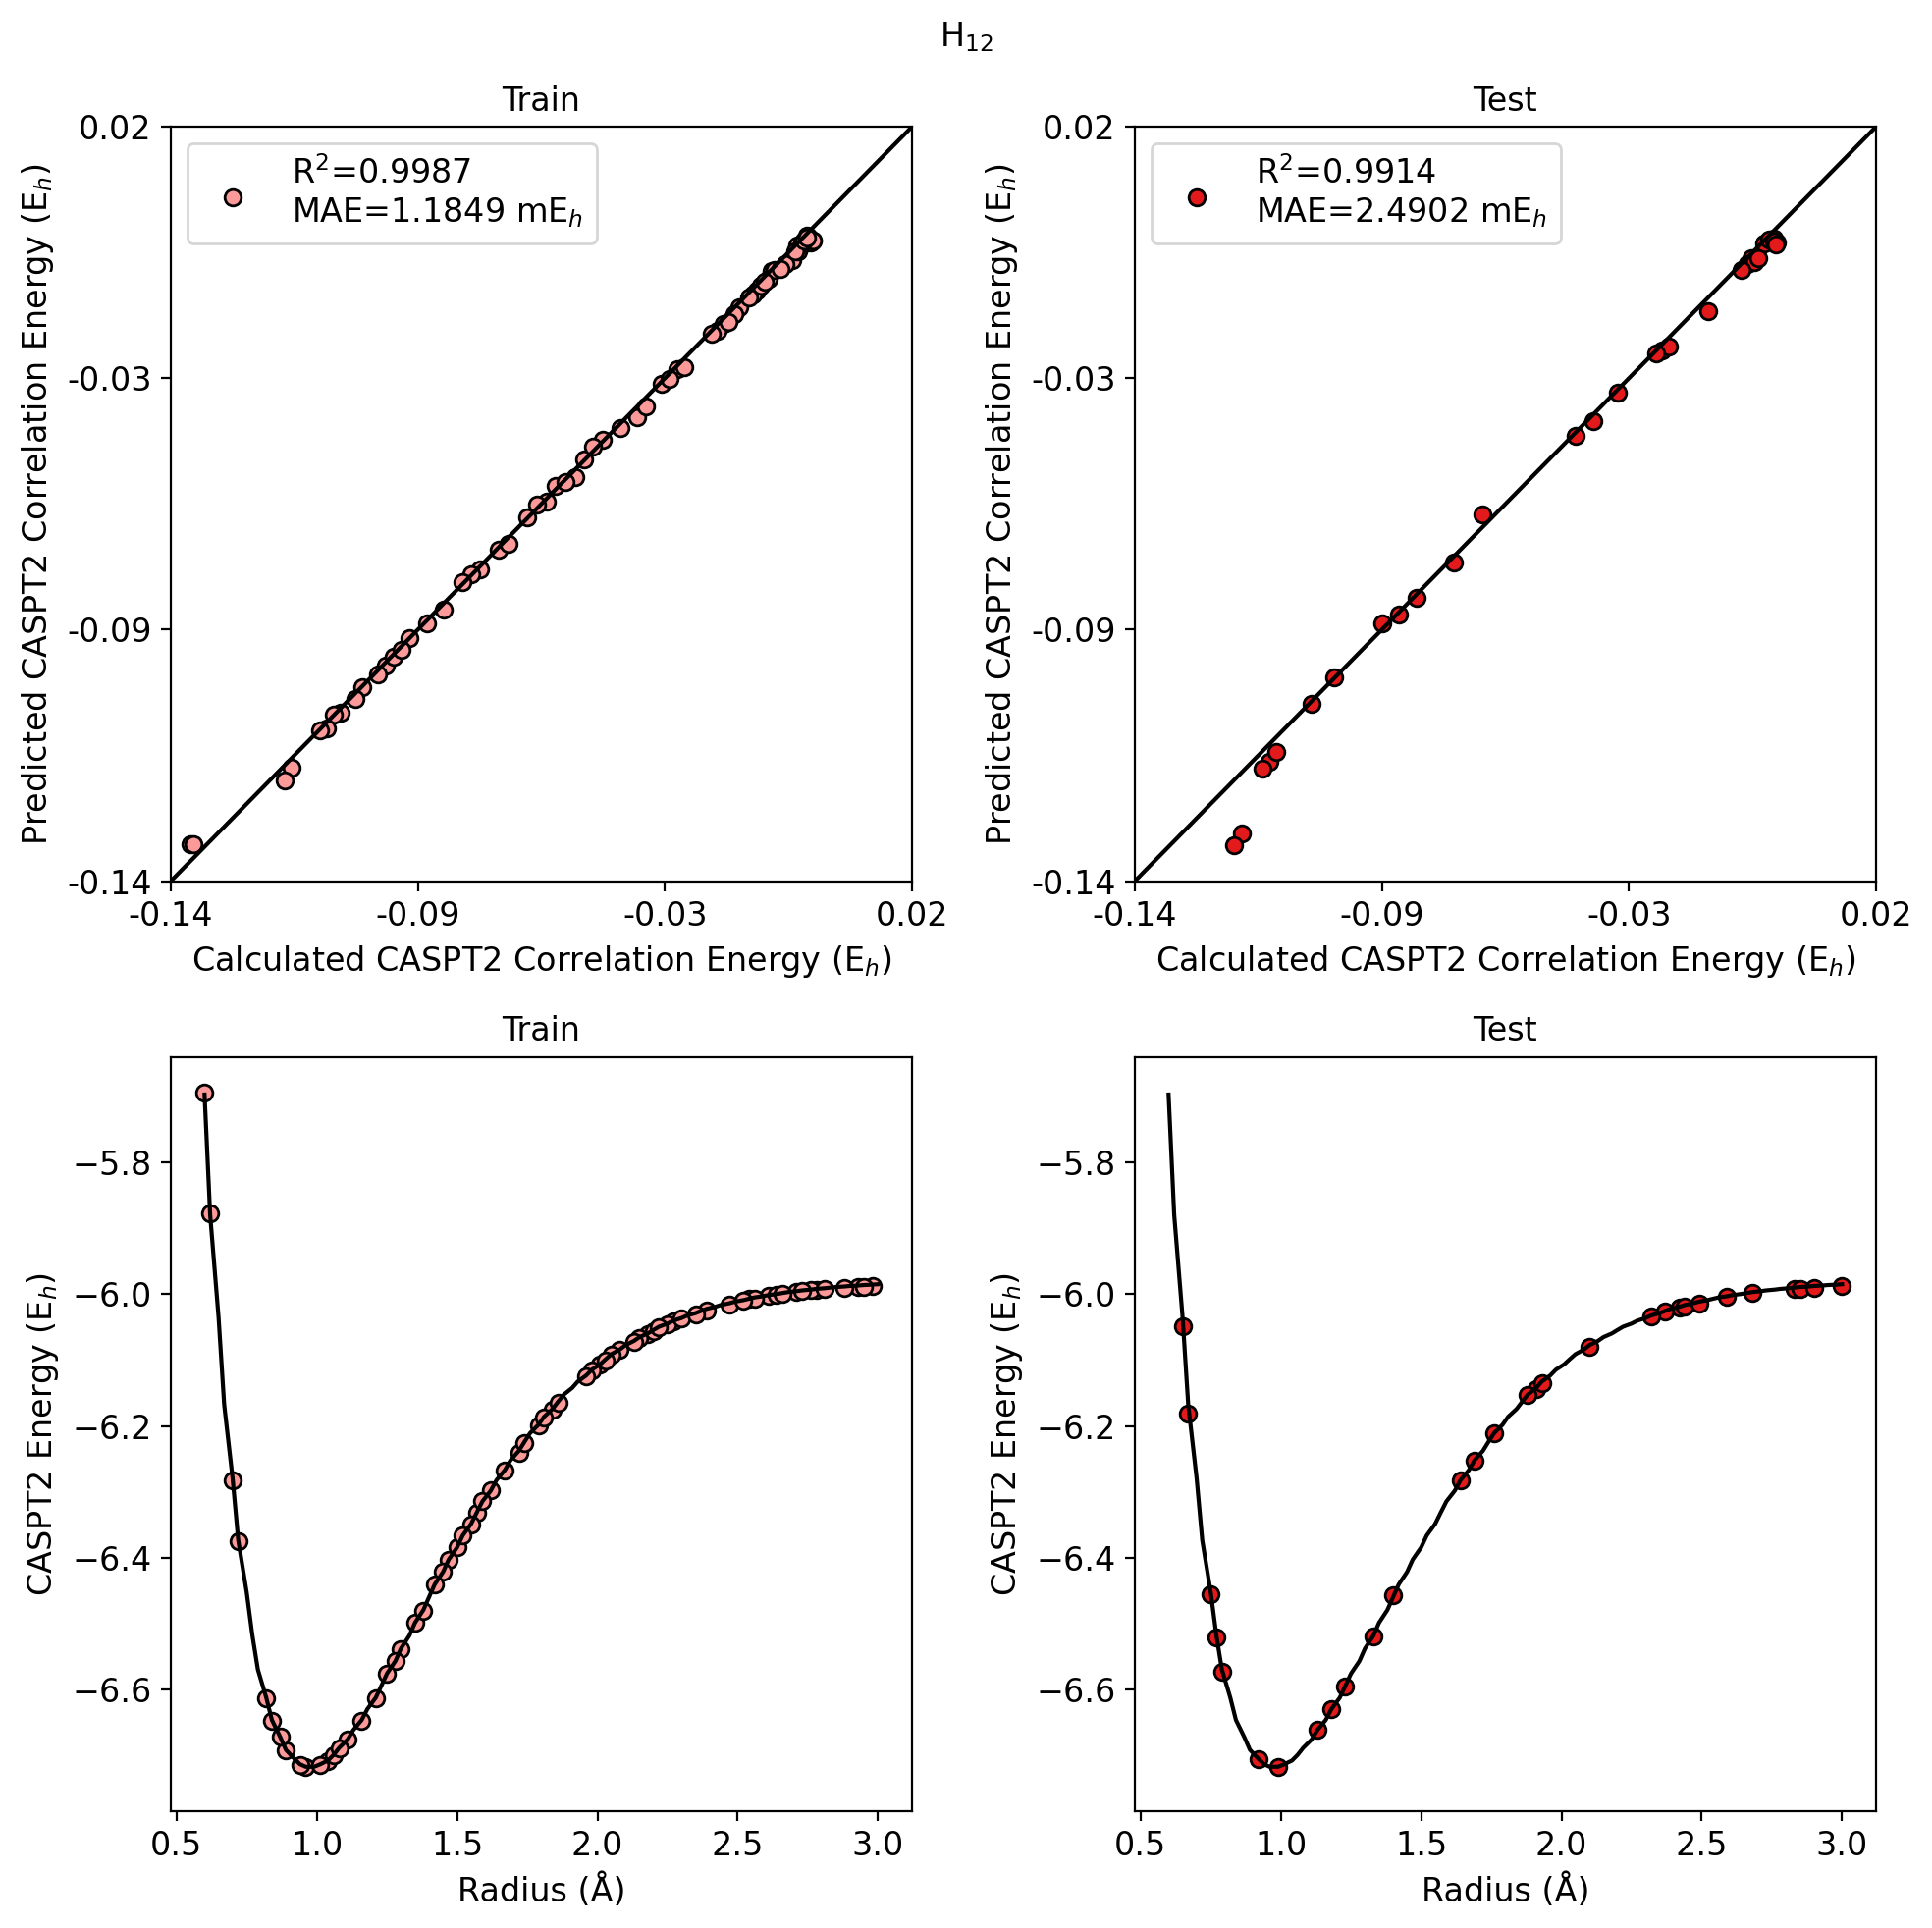

In [25]:
traincorrerr = {}
for n in sorted(set(traincaspt2melt['H$_{2n}$']),key=lambda x: int(x.replace("H",''))):
    fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,10),sharey=False)
    
    pred_train,true_train = traincorrE2[traincorrE2['H$_{2n}$']==n]['E$_{2}^{\text{Predicted}}$'],traincorrE2[traincorrE2['H$_{2n}$']==n]['E$_{2}^{\text{Calculated}}$']
    pred_test,true_test = testcorrE2[testcorrE2['H$_{2n}$']==n]['E$_{2}^{\text{Predicted}}$'],testcorrE2[testcorrE2['H$_{2n}$']==n]['E$_{2}^{\text{Calculated}}$']
    testrad = testcorrE2[testcorrE2['H$_{2n}$']==n]['Radius ($\AA$)']    
    train_r2_corr = r2_score(true_train,pred_train)
    test_r2_corr = r2_score(true_test,pred_test)
    test_mae_corr = 1e3*mean_absolute_error(true_test,pred_test)
    train_mae_corr = 1e3*mean_absolute_error(true_train,pred_train)
    
    traincorrerr[n] = {"r2_train":train_r2_corr,"r2_test":test_r2_corr,"mae_train":train_mae_corr,"mae_test":test_mae_corr}
    trainrad = traincorrE2[traincorrE2['H$_{2n}$']==n]['Radius ($\AA$)']

    
    ax1.scatter(true_train,pred_train,label='R$^{2}$='+f'{train_r2_corr:.4f}\nMAE={train_mae_corr:.4f}'+" mE$_{h}$",color=pairedcp[4],edgecolors='k')
    ax1.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
    ax1.set_xlabel('Calculated CASPT2 Correlation Energy (E$_{h}$)')
    ax1.set_ylabel('Predicted CASPT2 Correlation Energy (E$_{h}$)')
    ax1.set_title('Train')
    ax1.legend()


    ax2.scatter(true_test,pred_test,label='R$^{2}$='+f'{test_r2_corr:.4f}\nMAE={test_mae_corr:.4f}'+" mE$_{h}$",color=pairedcp[5],edgecolors='k')
    ax2.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
    ax2.set_xlabel('Calculated CASPT2 Correlation Energy (E$_{h}$)')
    ax2.set_ylabel('Predicted CASPT2 Correlation Energy (E$_{h}$)')
    ax2.set_title('Test')    
    ax2.legend()

    pred_train,true_train = traincorrE2[traincorrE2['H$_{2n}$']==n]['E$_{\text{CASPT2}}^{\text{Predicted}}$'],traincorrE2[traincorrE2['H$_{2n}$']==n]['E$_{\text{CASPT2}}^{\text{Calculated}}$']
    pred_test,true_test = testcorrE2[testcorrE2['H$_{2n}$']==n]['E$_{\text{CASPT2}}^{\text{Predicted}}$'],testcorrE2[testcorrE2['H$_{2n}$']==n]['E$_{\text{CASPT2}}^{\text{Calculated}}$']
    testrad = testcorrE2[testcorrE2['H$_{2n}$']==n]['Radius ($\AA$)']    
    train_r2_corr = r2_score(true_train,pred_train)
    test_r2_corr = r2_score(true_test,pred_test)
    test_mae_corr = 1e3*mean_absolute_error(true_test,pred_test)
    train_mae_corr = 1e3*mean_absolute_error(true_train,pred_train)
    
    traincorrerr[n] = {"r2_train":train_r2_corr,"r2_test":test_r2_corr,"mae_train":train_mae_corr,"mae_test":test_mae_corr}
    trainrad = traincorrE2[traincorrE2['H$_{2n}$']==n]['Radius ($\AA$)']
    
    ax3.scatter(np.array(trainrad,dtype=float),pred_train,color=pairedcp[4],edgecolors='k')
    ax3.plot(trueE2[trueE2['H$_{2n}$']==n].sort_values(by='Radius ($\AA$)')['Radius ($\AA$)'],trueE2[trueE2['H$_{2n}$']==n].sort_values(by='Radius ($\AA$)')['E$_{\text{CASPT2}}^{\text{Calculated}}$'],'k')
    ax3.set_xlabel('Radius (Å)')
    ax3.set_ylabel('CASPT2 Energy (E$_{h}$)')
    ax3.set_title('Train')
    
    ax4.scatter(np.array(testrad,dtype=float),pred_test,color=pairedcp[5],edgecolors='k')
    ax4.plot(trueE2[trueE2['H$_{2n}$']==n].sort_values(by='Radius ($\AA$)')['Radius ($\AA$)'],trueE2[trueE2['H$_{2n}$']==n].sort_values(by='Radius ($\AA$)')['E$_{\text{CASPT2}}^{\text{Calculated}}$'],'k')
    ax4.set_xlabel('Radius (Å)')
    ax4.set_ylabel('CASPT2 Energy (E$_{h}$)')
    ax4.set_title('Test') 
    

    
    bottom, top = -0.14, 0.02
    ax1.set_xlim(bottom, top)
    ax1.set_ylim(bottom, top)
    ax2.set_xlim(bottom, top)
    ax2.set_ylim(bottom, top)
    ax1.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])
    ax1.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
    ax2.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
    ax2.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])   
    
    minpt2, maxpt2= pd.concat([true_train,true_test]).min(), pd.concat([true_train,true_test]).max()
    pct=0.01
    bufferbot, buffertop = minpt2*pct, maxpt2*pct
    ax3.set_ylim(minpt2+bufferbot, maxpt2-buffertop)
    # ax3.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)]) 
    ax4.set_ylim(minpt2+bufferbot, maxpt2-buffertop)
    # ax4.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)]) 

    fig.suptitle("H$_{"+re.findall(r'\d+',n)[0]+"}$")
    
    plt.subplots_adjust(wspace=0.05)
    plt.tight_layout()
    plt.savefig(f'images/{n}_CASPT2.png',dpi=300,bbox_inches='tight')
    plt.show()    

H2


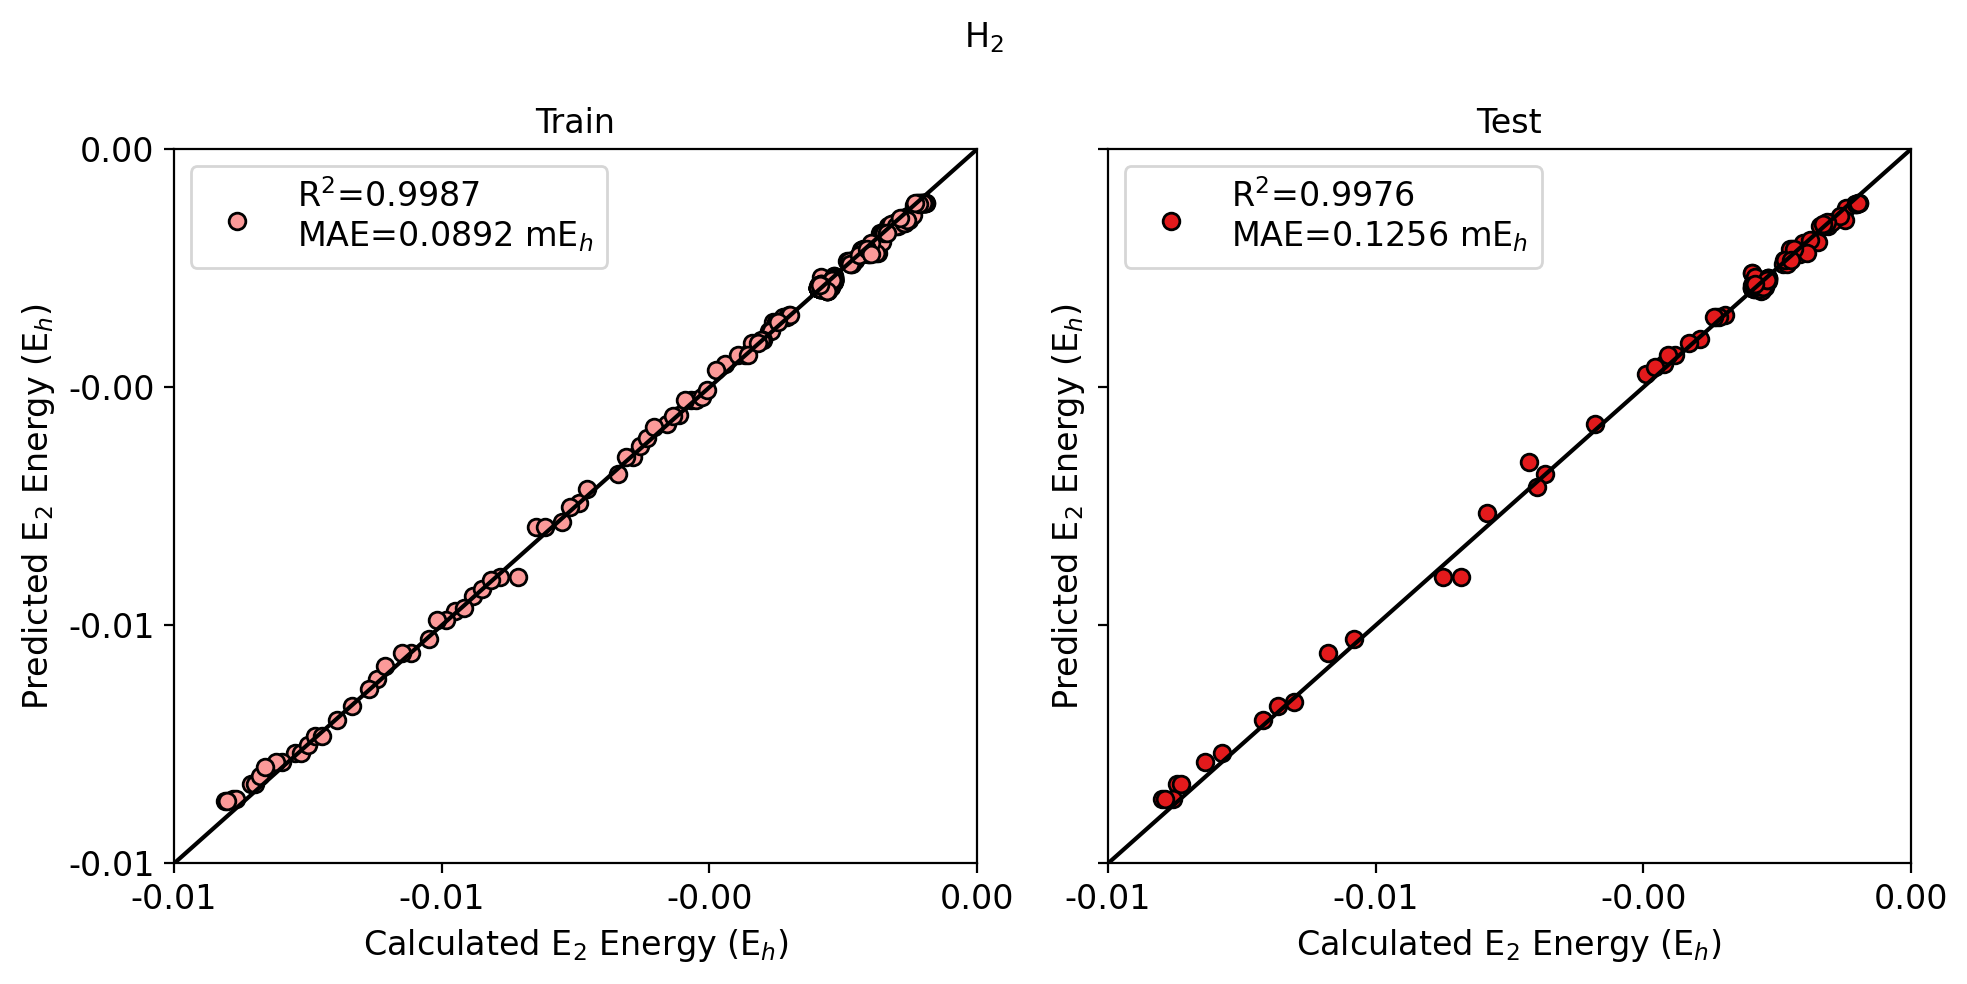

H4


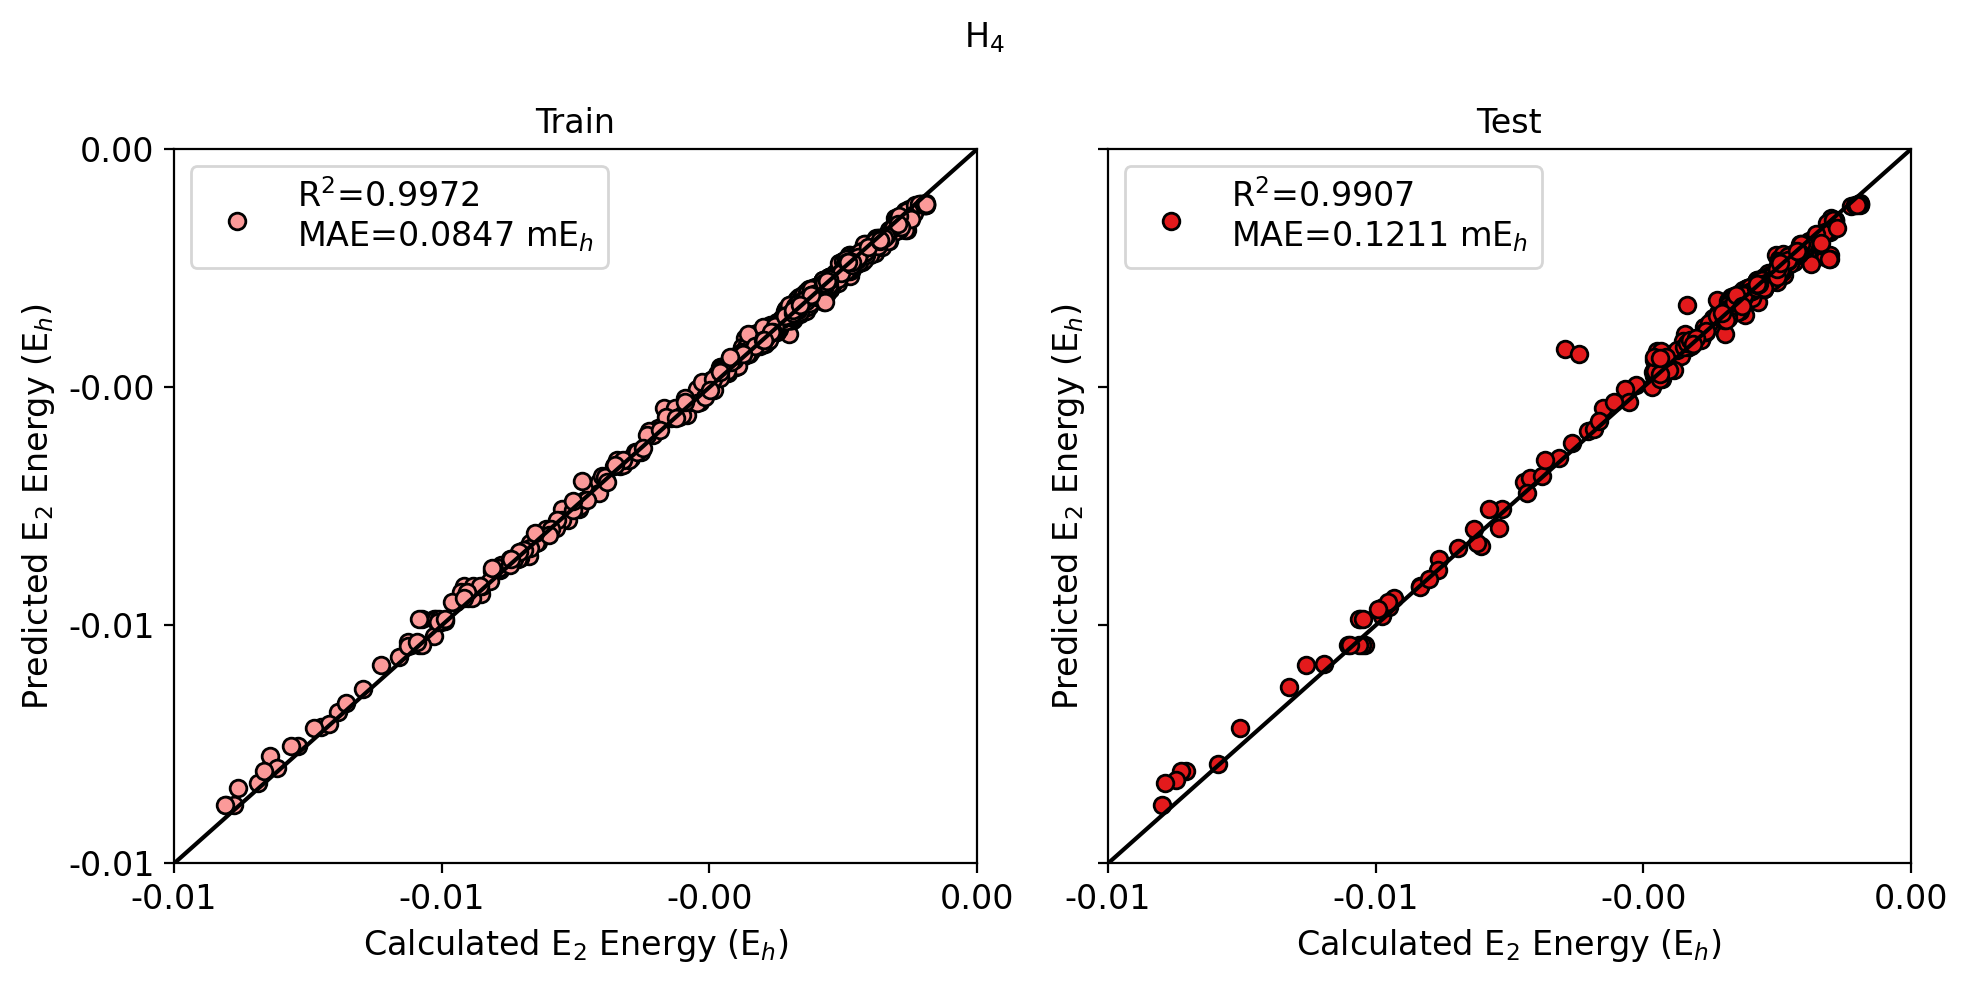

H6


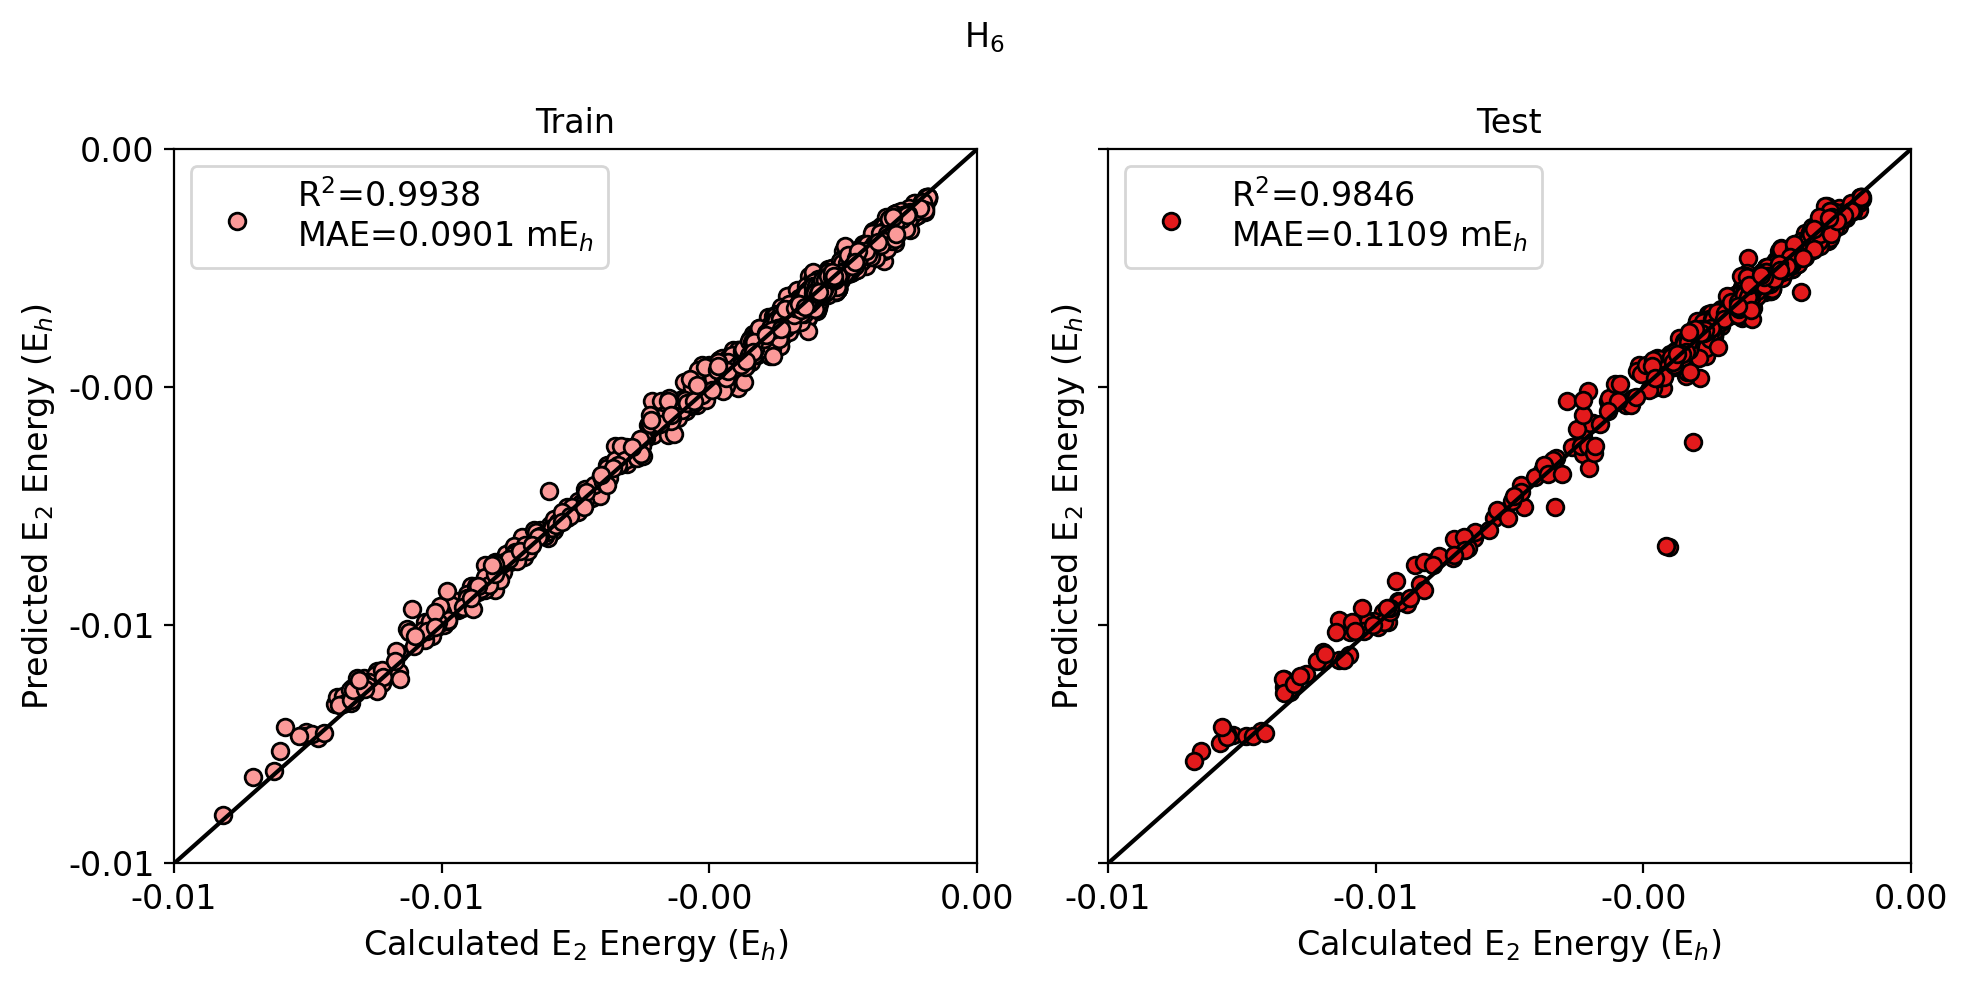

H8


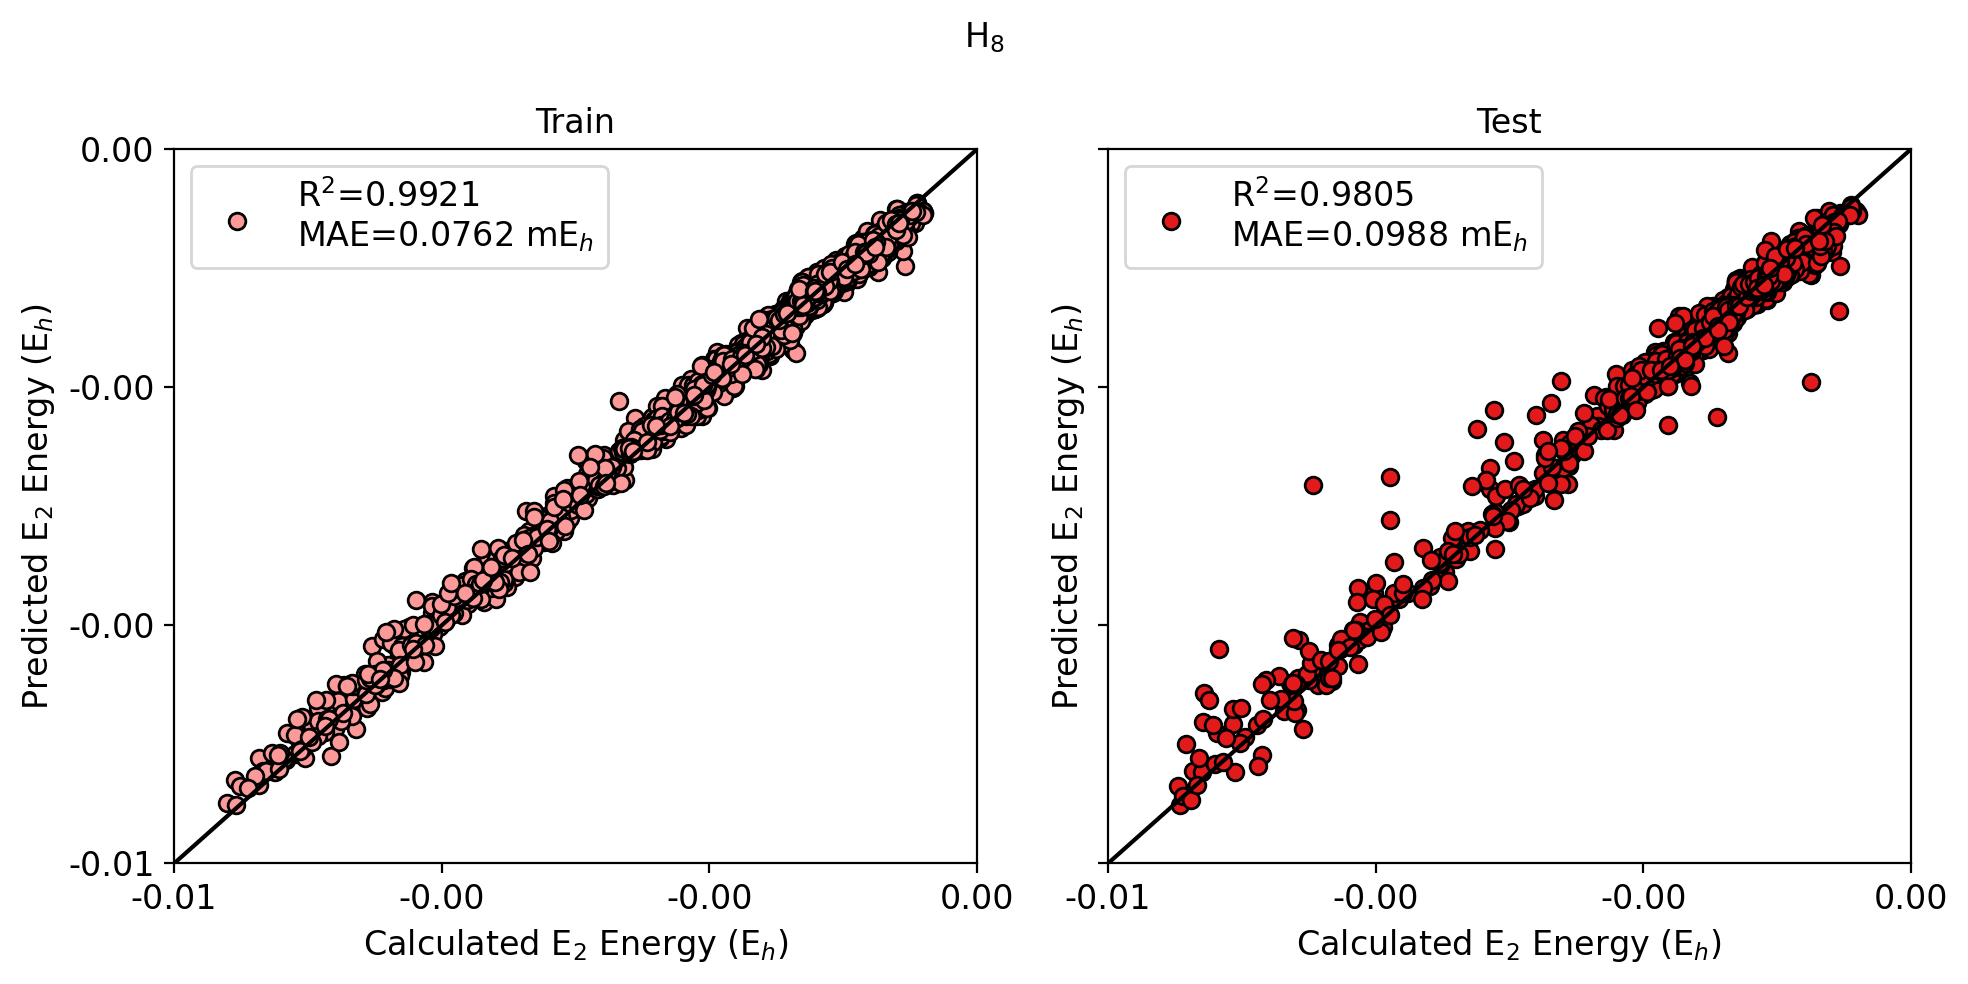

H10


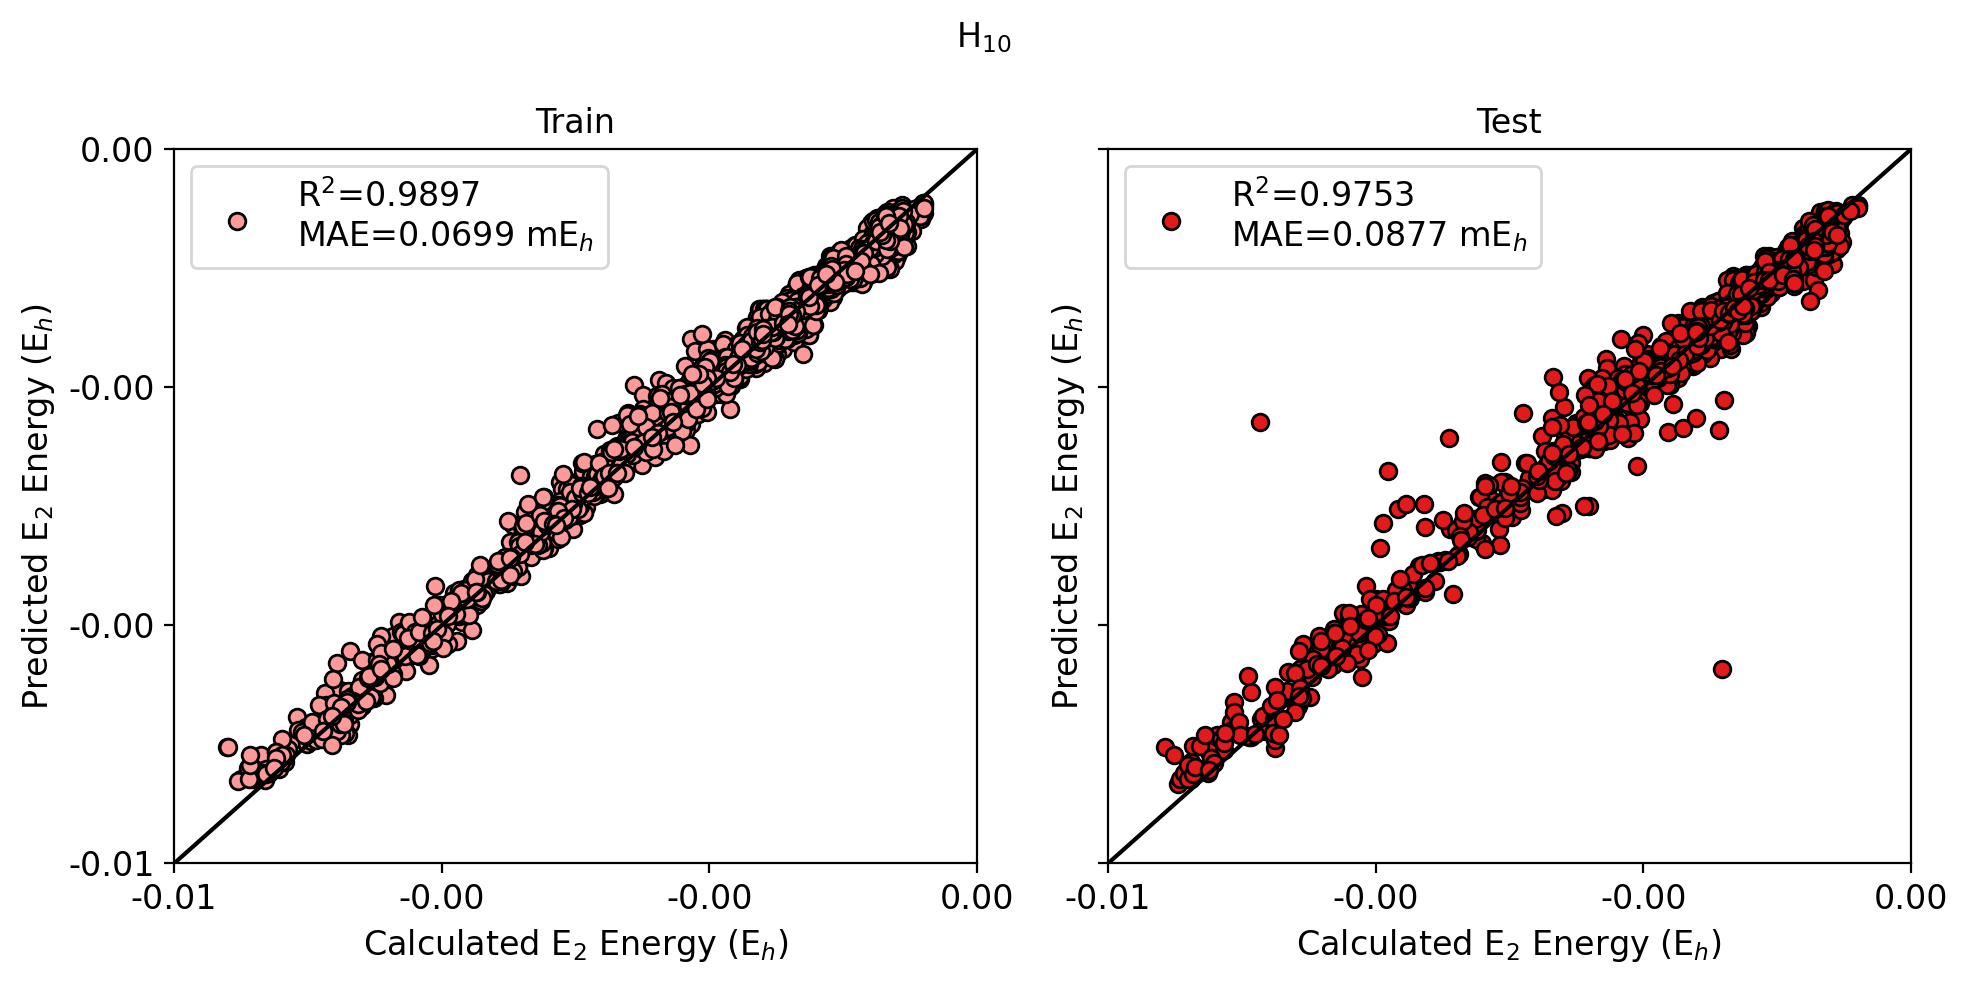

H12


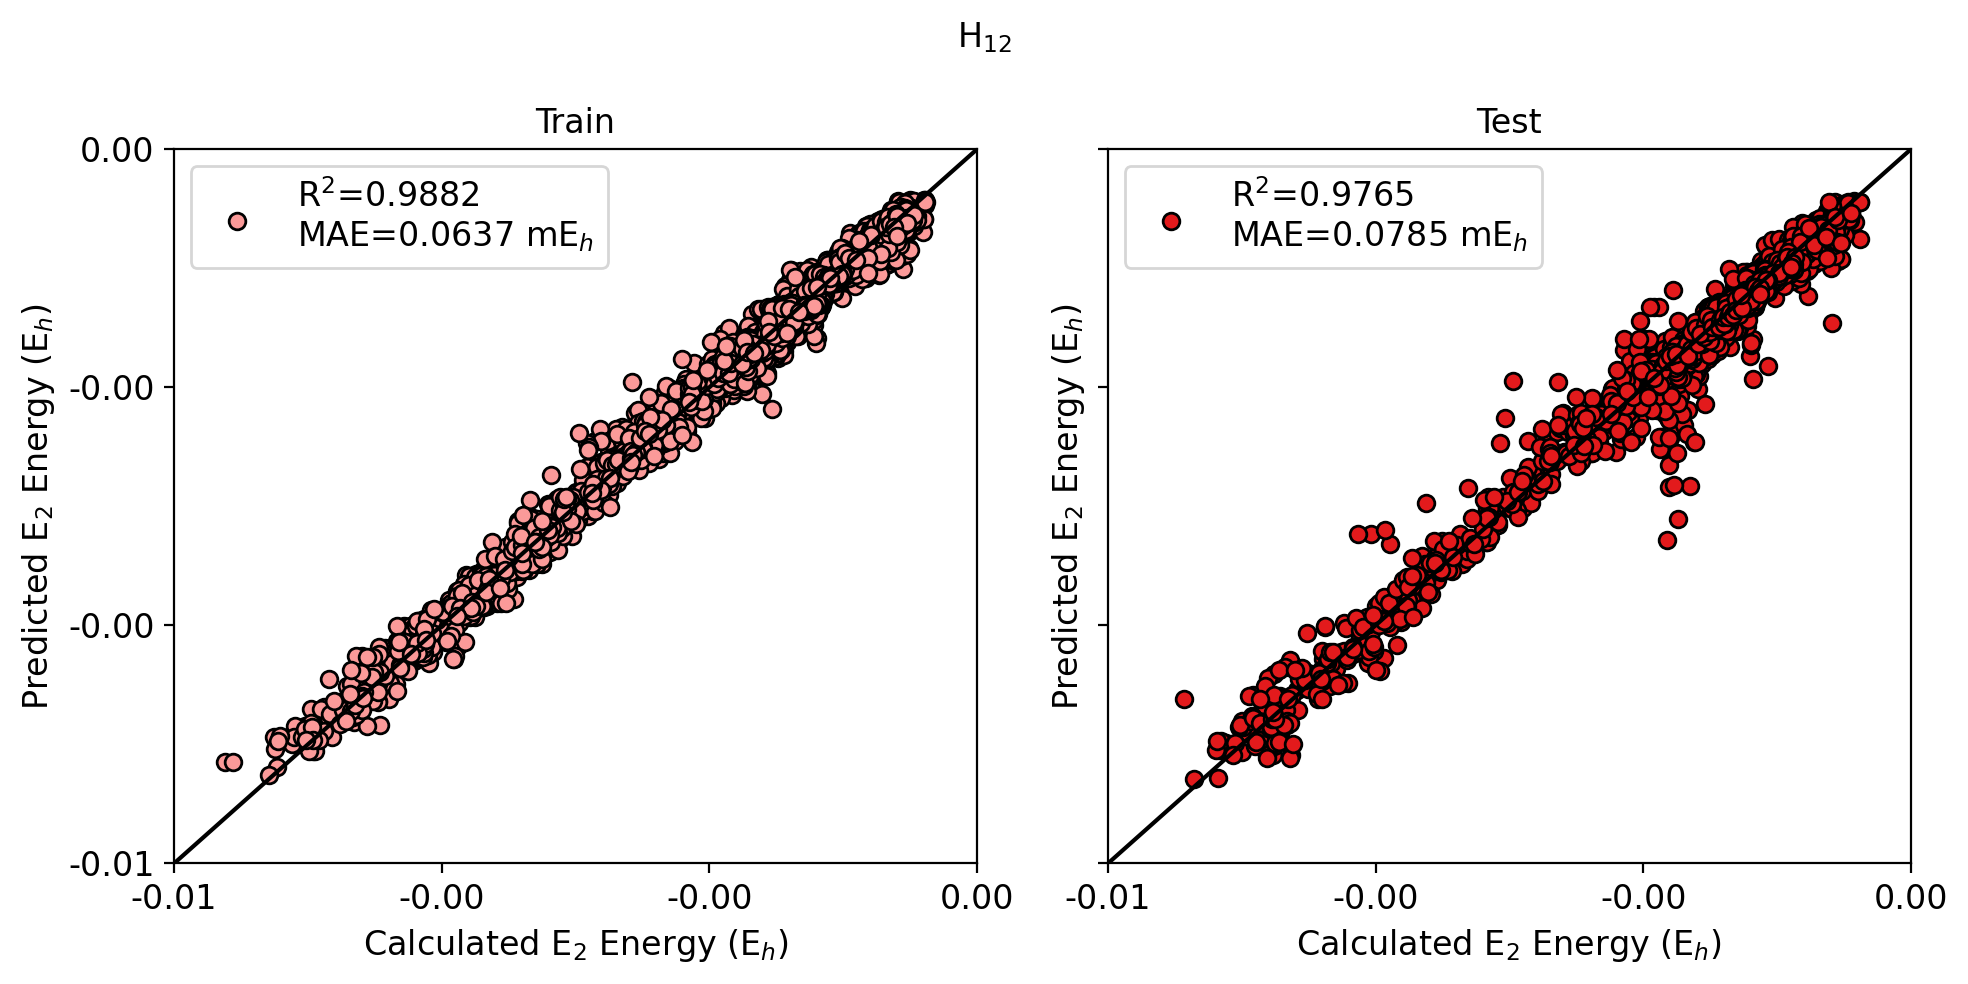

In [26]:
trainpairdf = pd.DataFrame(recover_train_list)
testpairdf = pd.DataFrame(recover_test_list)
pairerr={}
for n in sorted(set(traincaspt2melt['H$_{2n}$']),key=lambda x: int(x.replace("H",''))):
    print(n)
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)
    
    truetrainpair, predtrainpair = np.hstack(trainpairdf[trainpairdf[0]==n][2]),np.hstack(trainpairdf[trainpairdf[0]==n][3])
    train_r2_pair = r2_score(truetrainpair, predtrainpair)
    train_mae_pair = 1e3*mean_absolute_error(truetrainpair, predtrainpair)
    ax1.scatter(truetrainpair, predtrainpair,label='R$^{2}$='+f'{train_r2_pair:.4f}\nMAE={train_mae_pair:.4f}'+" mE$_{h}$",color=pairedcp[4],edgecolors='k')
    ax1.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
    ax1.set_xlabel('Calculated E$_2$ Energy (E$_{h}$)')
    ax1.set_ylabel('Predicted E$_2$ Energy (E$_{h}$)')
    ax1.set_title('Train')    
    ax1.legend()  
    
    truetestpair, predtestpair = np.hstack(testpairdf[testpairdf[0]==n][2]),np.hstack(testpairdf[testpairdf[0]==n][3])
    test_r2_pair = r2_score(truetestpair, predtestpair)
    test_mae_pair = 1e3*mean_absolute_error(truetestpair, predtestpair)
    ax2.scatter(truetestpair, predtestpair,label='R$^{2}$='+f'{test_r2_pair:.4f}\nMAE={test_mae_pair:.4f}'+" mE$_{h}$",color=pairedcp[5],edgecolors='k')
    ax2.set_xlabel('Calculated E$_2$ Energy (E$_{h}$)')
    ax2.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
    ax2.set_ylabel('Predicted E$_2$ Energy (E$_{h}$)')
    ax2.set_title('Test')    
    ax2.legend()  

    mincorr, maxcorr= np.hstack([truetrainpair,truetestpair]).min(), np.hstack([truetrainpair,truetestpair]).max()
    pct=0.50
    bufferbot, buffertop = mincorr*pct, maxcorr*pct

    # if 'H' in n:
    bottom, top = mincorr-buffertop, maxcorr+buffertop
    
    # else:
    #     bottom, top = mincorr+-0.1, maxcorr+0.05

    ax1.set_xlim(bottom,top)
    ax1.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])
    ax1.set_ylim(bottom,top)
    ax1.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
    ax2.set_xlim(bottom,top)
    ax2.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
    ax2.set_ylim(bottom,top)
    ax2.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])  
    
    fig.suptitle("H$_{"+re.findall(r'\d+',n)[0]+"}$")
    plt.tight_layout()
    plt.savefig(f'images/{n}_E2.png',dpi=300,bbox_inches='tight')    
    plt.show()
    pairerr[n] = {"r2_train":train_r2_pair,"r2_test":test_r2_pair,"mae_train":train_mae_pair,"mae_test":test_mae_pair}

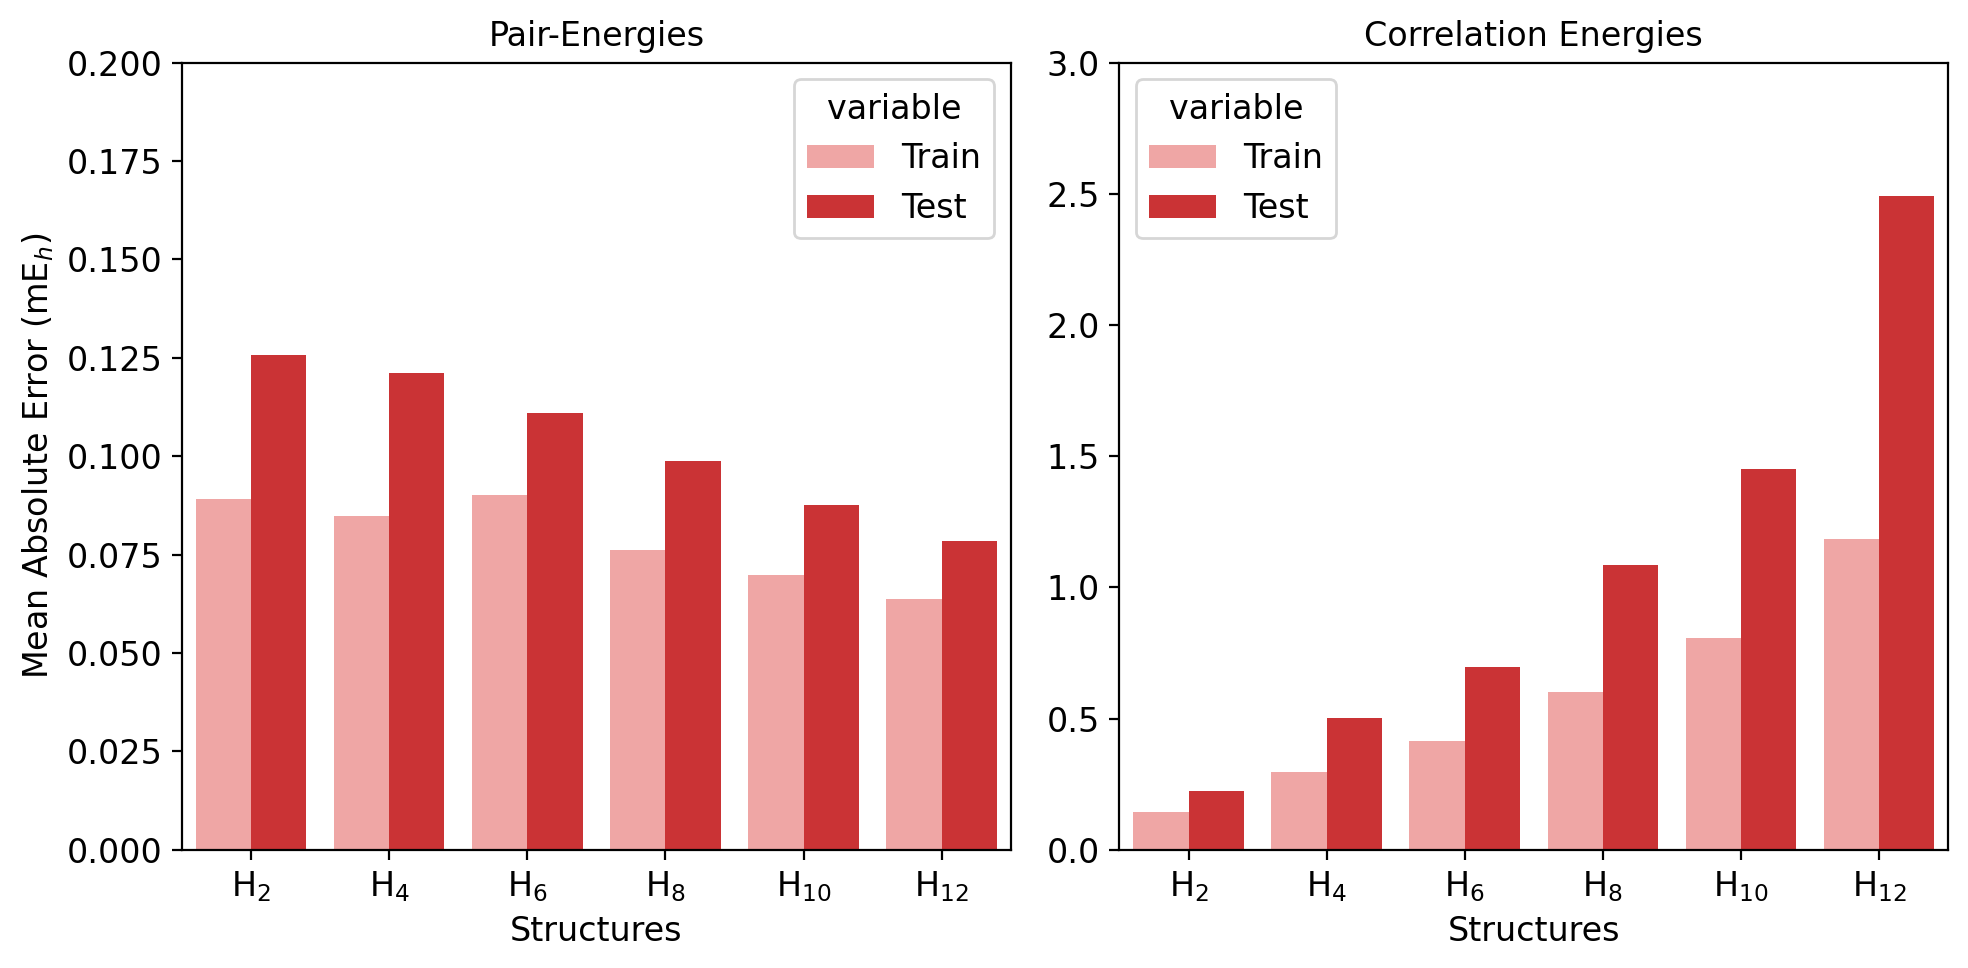

In [27]:
meltcorrerr = pd.DataFrame.from_dict(traincorrerr).loc[['mae_train','mae_test']].T.rename(columns={'mae_train':'Train','mae_test':'Test'}).reset_index().melt(id_vars=['index'], value_vars=['Train','Test'])
meltcorrerr['index'] = ['H$_{2}$', 'H$_{4}$', 'H$_{6}$', 'H$_{8}$', 'H$_{10}$', 'H$_{12}$', 'H$_{2}$', 'H$_{4}$', 'H$_{6}$', 'H$_{8}$', 'H$_{10}$', 'H$_{12}$']
meltpairerr = pd.DataFrame.from_dict(pairerr).loc[['mae_train','mae_test']].T.rename(columns={'mae_train':'Train','mae_test':'Test'}).reset_index().melt(id_vars=['index'], value_vars=['Train','Test'])
meltpairerr['index'] = ['H$_{2}$', 'H$_{4}$', 'H$_{6}$', 'H$_{8}$', 'H$_{10}$', 'H$_{12}$', 'H$_{2}$', 'H$_{4}$', 'H$_{6}$', 'H$_{8}$', 'H$_{10}$', 'H$_{12}$']
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=False)
sns.barplot(data=meltpairerr,x='index',y='value',hue='variable',palette=pairedcp[4:6],ax=ax1)
ax1.set_ylabel('Mean Absolute Error (mE$_{h}$)')
ax1.set_xlabel('Structures')
ax1.set_title('Pair-Energies')
ax1.set_ylim(0,0.2)
sns.barplot(data=meltcorrerr,x='index',y='value',hue='variable',palette=pairedcp[4:6],ax=ax2)
# ax2.set_ylabel('Mean Absolute Error (mE$_{h}$)')
ax2.set_ylabel('')
ax2.set_ylim(0,3)
ax2.set_xlabel('Structures')
ax2.set_title('Correlation Energies')

plt.tight_layout()
plt.savefig('images/MAE_bar.png',dpi=300,bbox_inches='tight')
plt.show()

In [28]:
meltcorrerr.to_excel('meltcorrMAE.xlsx')
meltpairerr.to_excel('meltpairMAE.xlsx')

In [29]:
import shap
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)



PermutationExplainer explainer: 10921it [08:58, 19.98it/s]                                                


In [30]:
dffeat=pd.DataFrame(shap_values.abs.values.mean(axis=0),index=train_df.drop(columns=['Pair_Energies']).columns,columns=['shap']).rename(index={'1':'$\mathbf{b}$'}).reset_index().rename(columns={'index':'feat'}).sort_index().sort_values(by=['shap','feat'],ascending=False)
# dffeat['rename']=len(dffeat)*[1]


In [31]:
with open('feature_names.txt','w') as f:
    for i in dffeat['feat'].values:
        f.write(i+'\n')

# with open('feature_names.txt','w') as f:
#     for i in dffeat['feat'].values:
#         f.write(i+'\n')

In [32]:
dffeat.to_excel('Hn_SHAP.xlsx')

0 [0, 35]
1 [35, 70]
2 [70, 105]


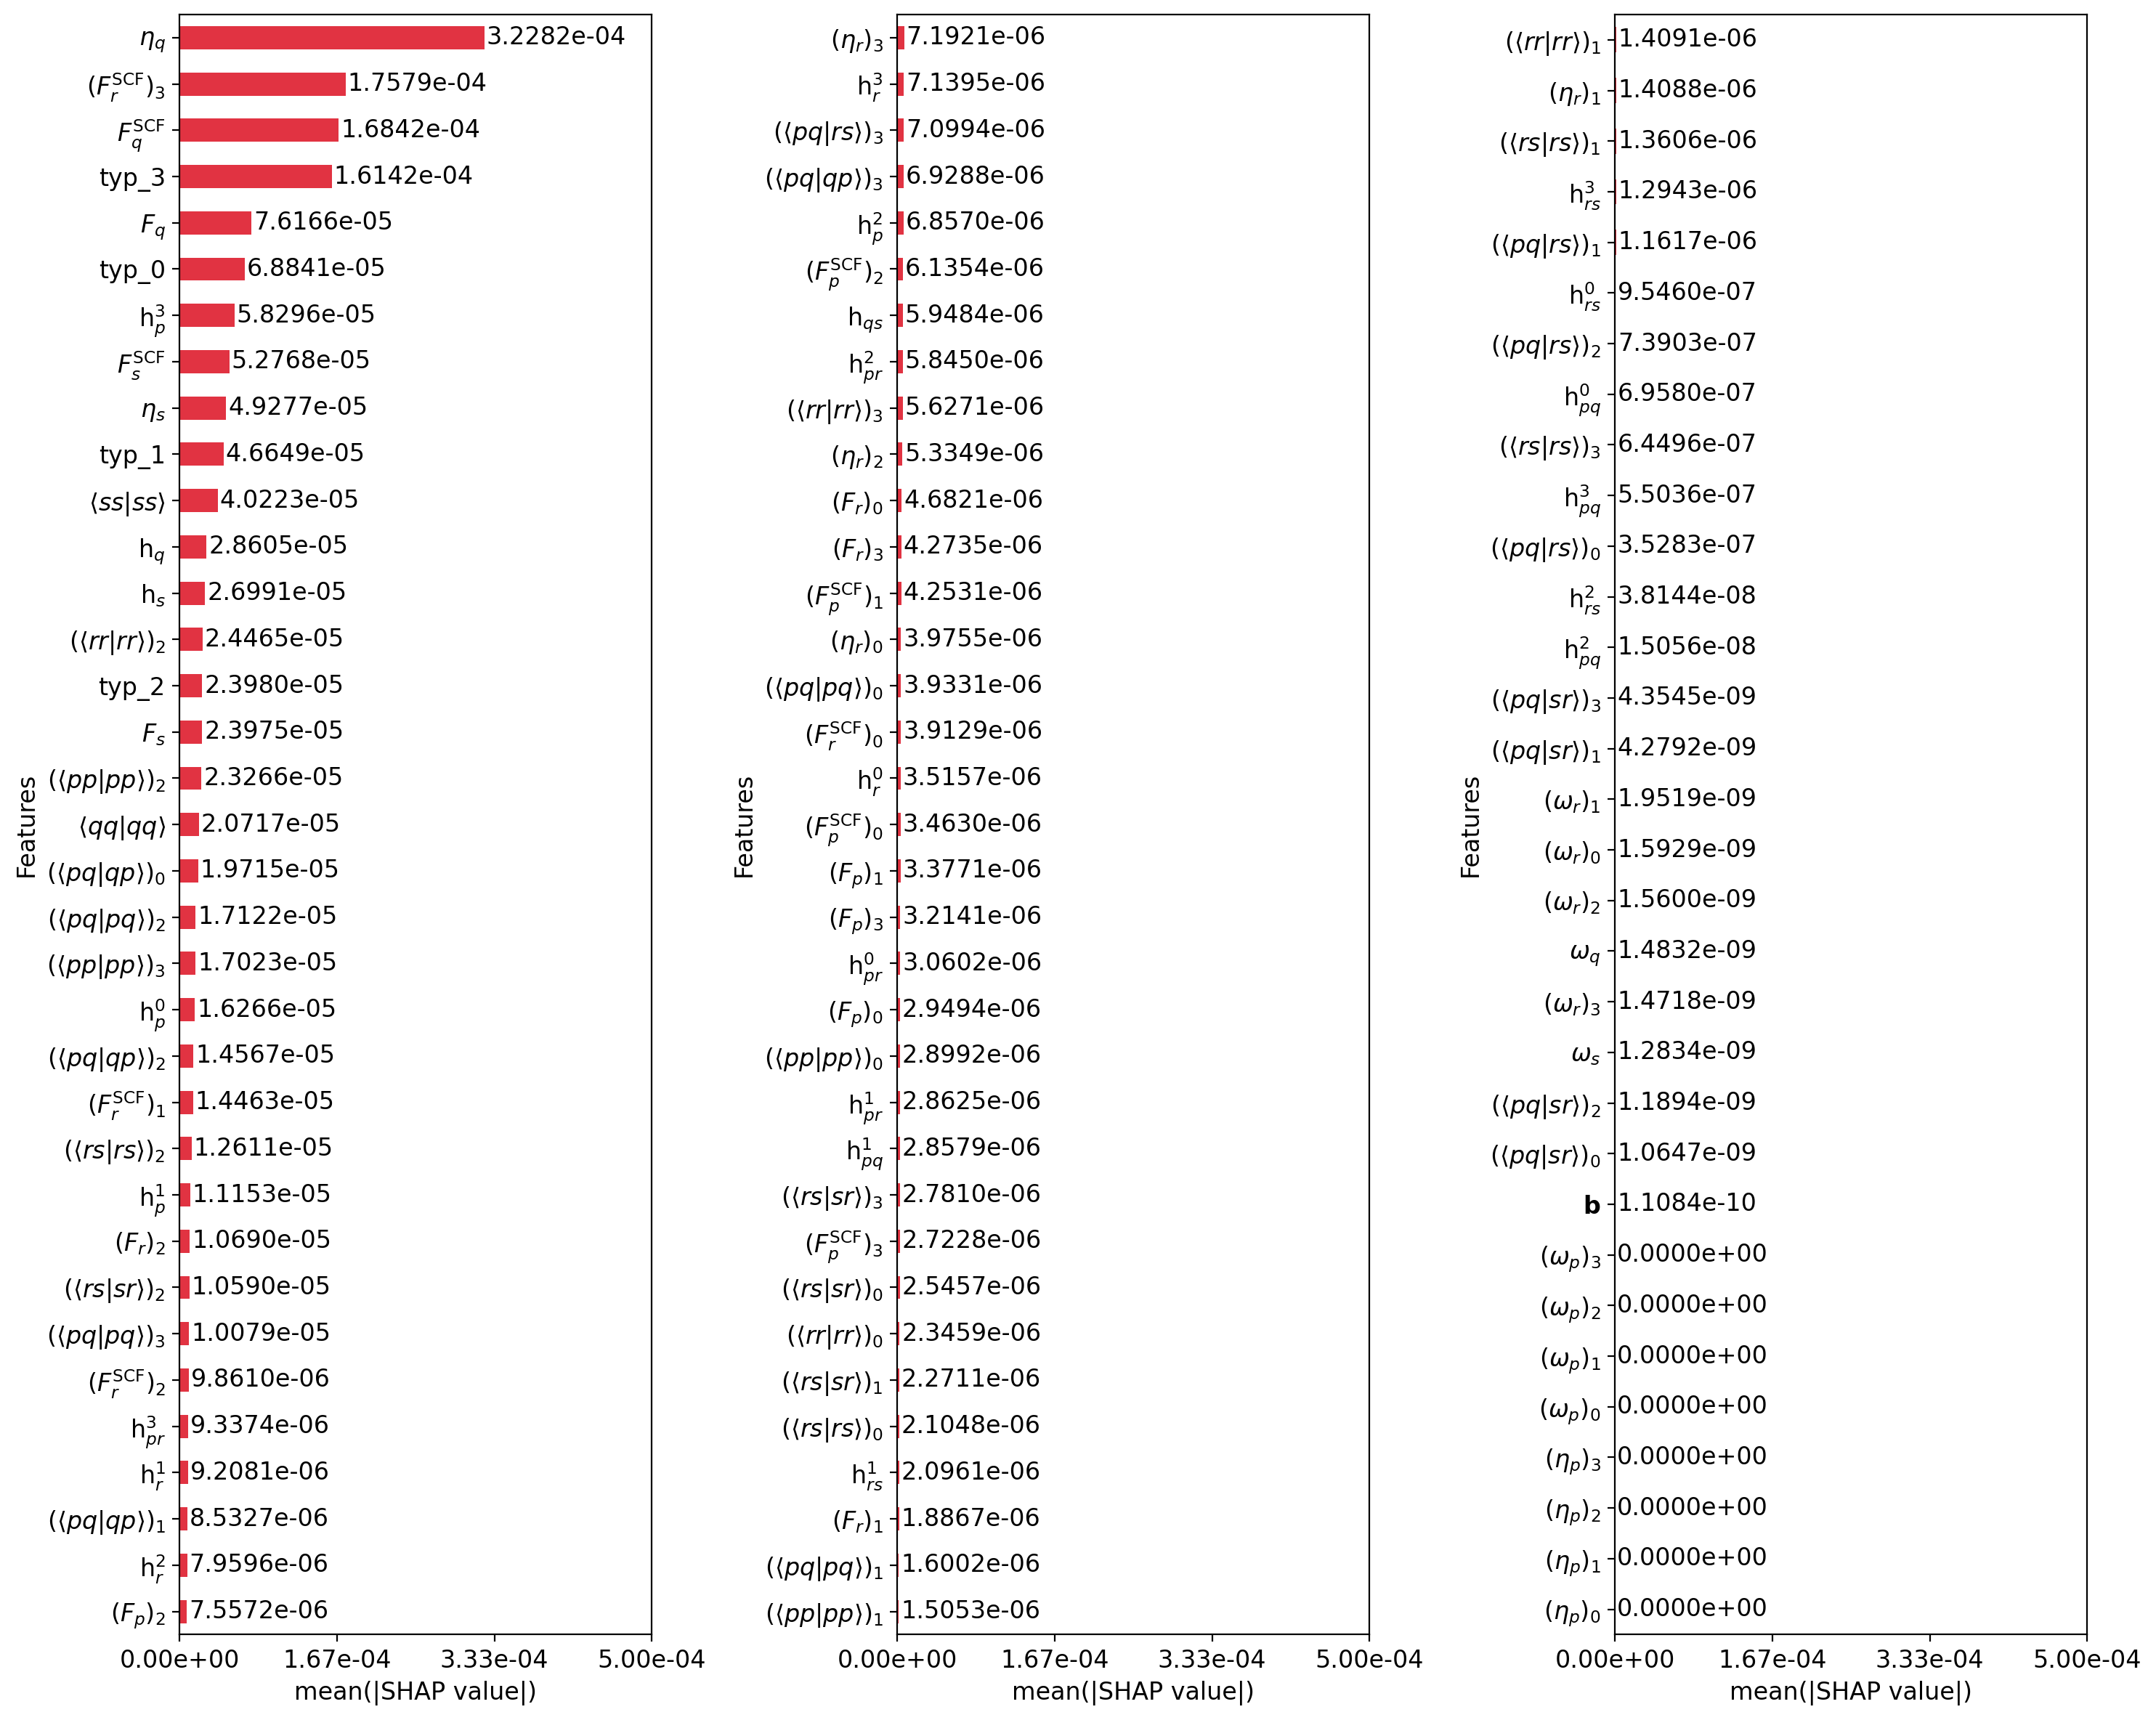

In [33]:
# color_map=sns.color_palette('rocket',6)
# fontsize = 12
# fig, ax = plt.subplots(1,3,figsize=(15,12))
# for idx, i in enumerate([[ 0,  32], [42,  64], [64, 96]]):
#     print(idx,i)
#     feat_1 = dffeat.iloc[i[0]:i[1]]
#     ax[idx]=feat_1.sort_values(by=['shap','feat']).plot.barh(x='feat',y='shap',legend=False,color=color_map[3],fontsize=fontsize,ax=ax[idx])
#     ax[idx].bar_label(ax[idx].containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
#     ax[idx].set_xlim(0,5e-4)
#     ax[idx].set_xticks(np.linspace(0,5e-4,4),[f"{i:.2e}" for i in np.linspace(0,5e-4,4)])
#     ax[idx].set_ylabel('Features',fontsize=fontsize)
#     ax[idx].set_xlabel('mean(|SHAP value|)',fontsize=fontsize)

# fig.subplots_adjust(wspace=0, hspace=0)

# plt.tight_layout()
# plt.savefig('images/Hn_shap_bar.png',dpi=300, bbox_inches='tight')
# plt.show()

color_map=sns.color_palette('rocket',6)
fontsize = 12
fig, ax = plt.subplots(1,3,figsize=(15,12))
for idx, i in enumerate([[ 0,  35], [35,  70], [70, 105]]):
    print(idx,i)
    feat_1 = dffeat.iloc[i[0]:i[1]]
    ax[idx]=feat_1.sort_values(by=['shap','feat']).plot.barh(x='feat',y='shap',legend=False,color=color_map[3],fontsize=fontsize,ax=ax[idx])
    ax[idx].bar_label(ax[idx].containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
    ax[idx].set_xlim(0,5e-4)
    ax[idx].set_xticks(np.linspace(0,5e-4,4),[f"{i:.2e}" for i in np.linspace(0,5e-4,4)])
    ax[idx].set_ylabel('Features',fontsize=fontsize)
    ax[idx].set_xlabel('mean(|SHAP value|)',fontsize=fontsize)

fig.subplots_adjust(wspace=0, hspace=0)

plt.tight_layout()
plt.savefig('images/Hn_shap_bar.png',dpi=300, bbox_inches='tight')
plt.show()

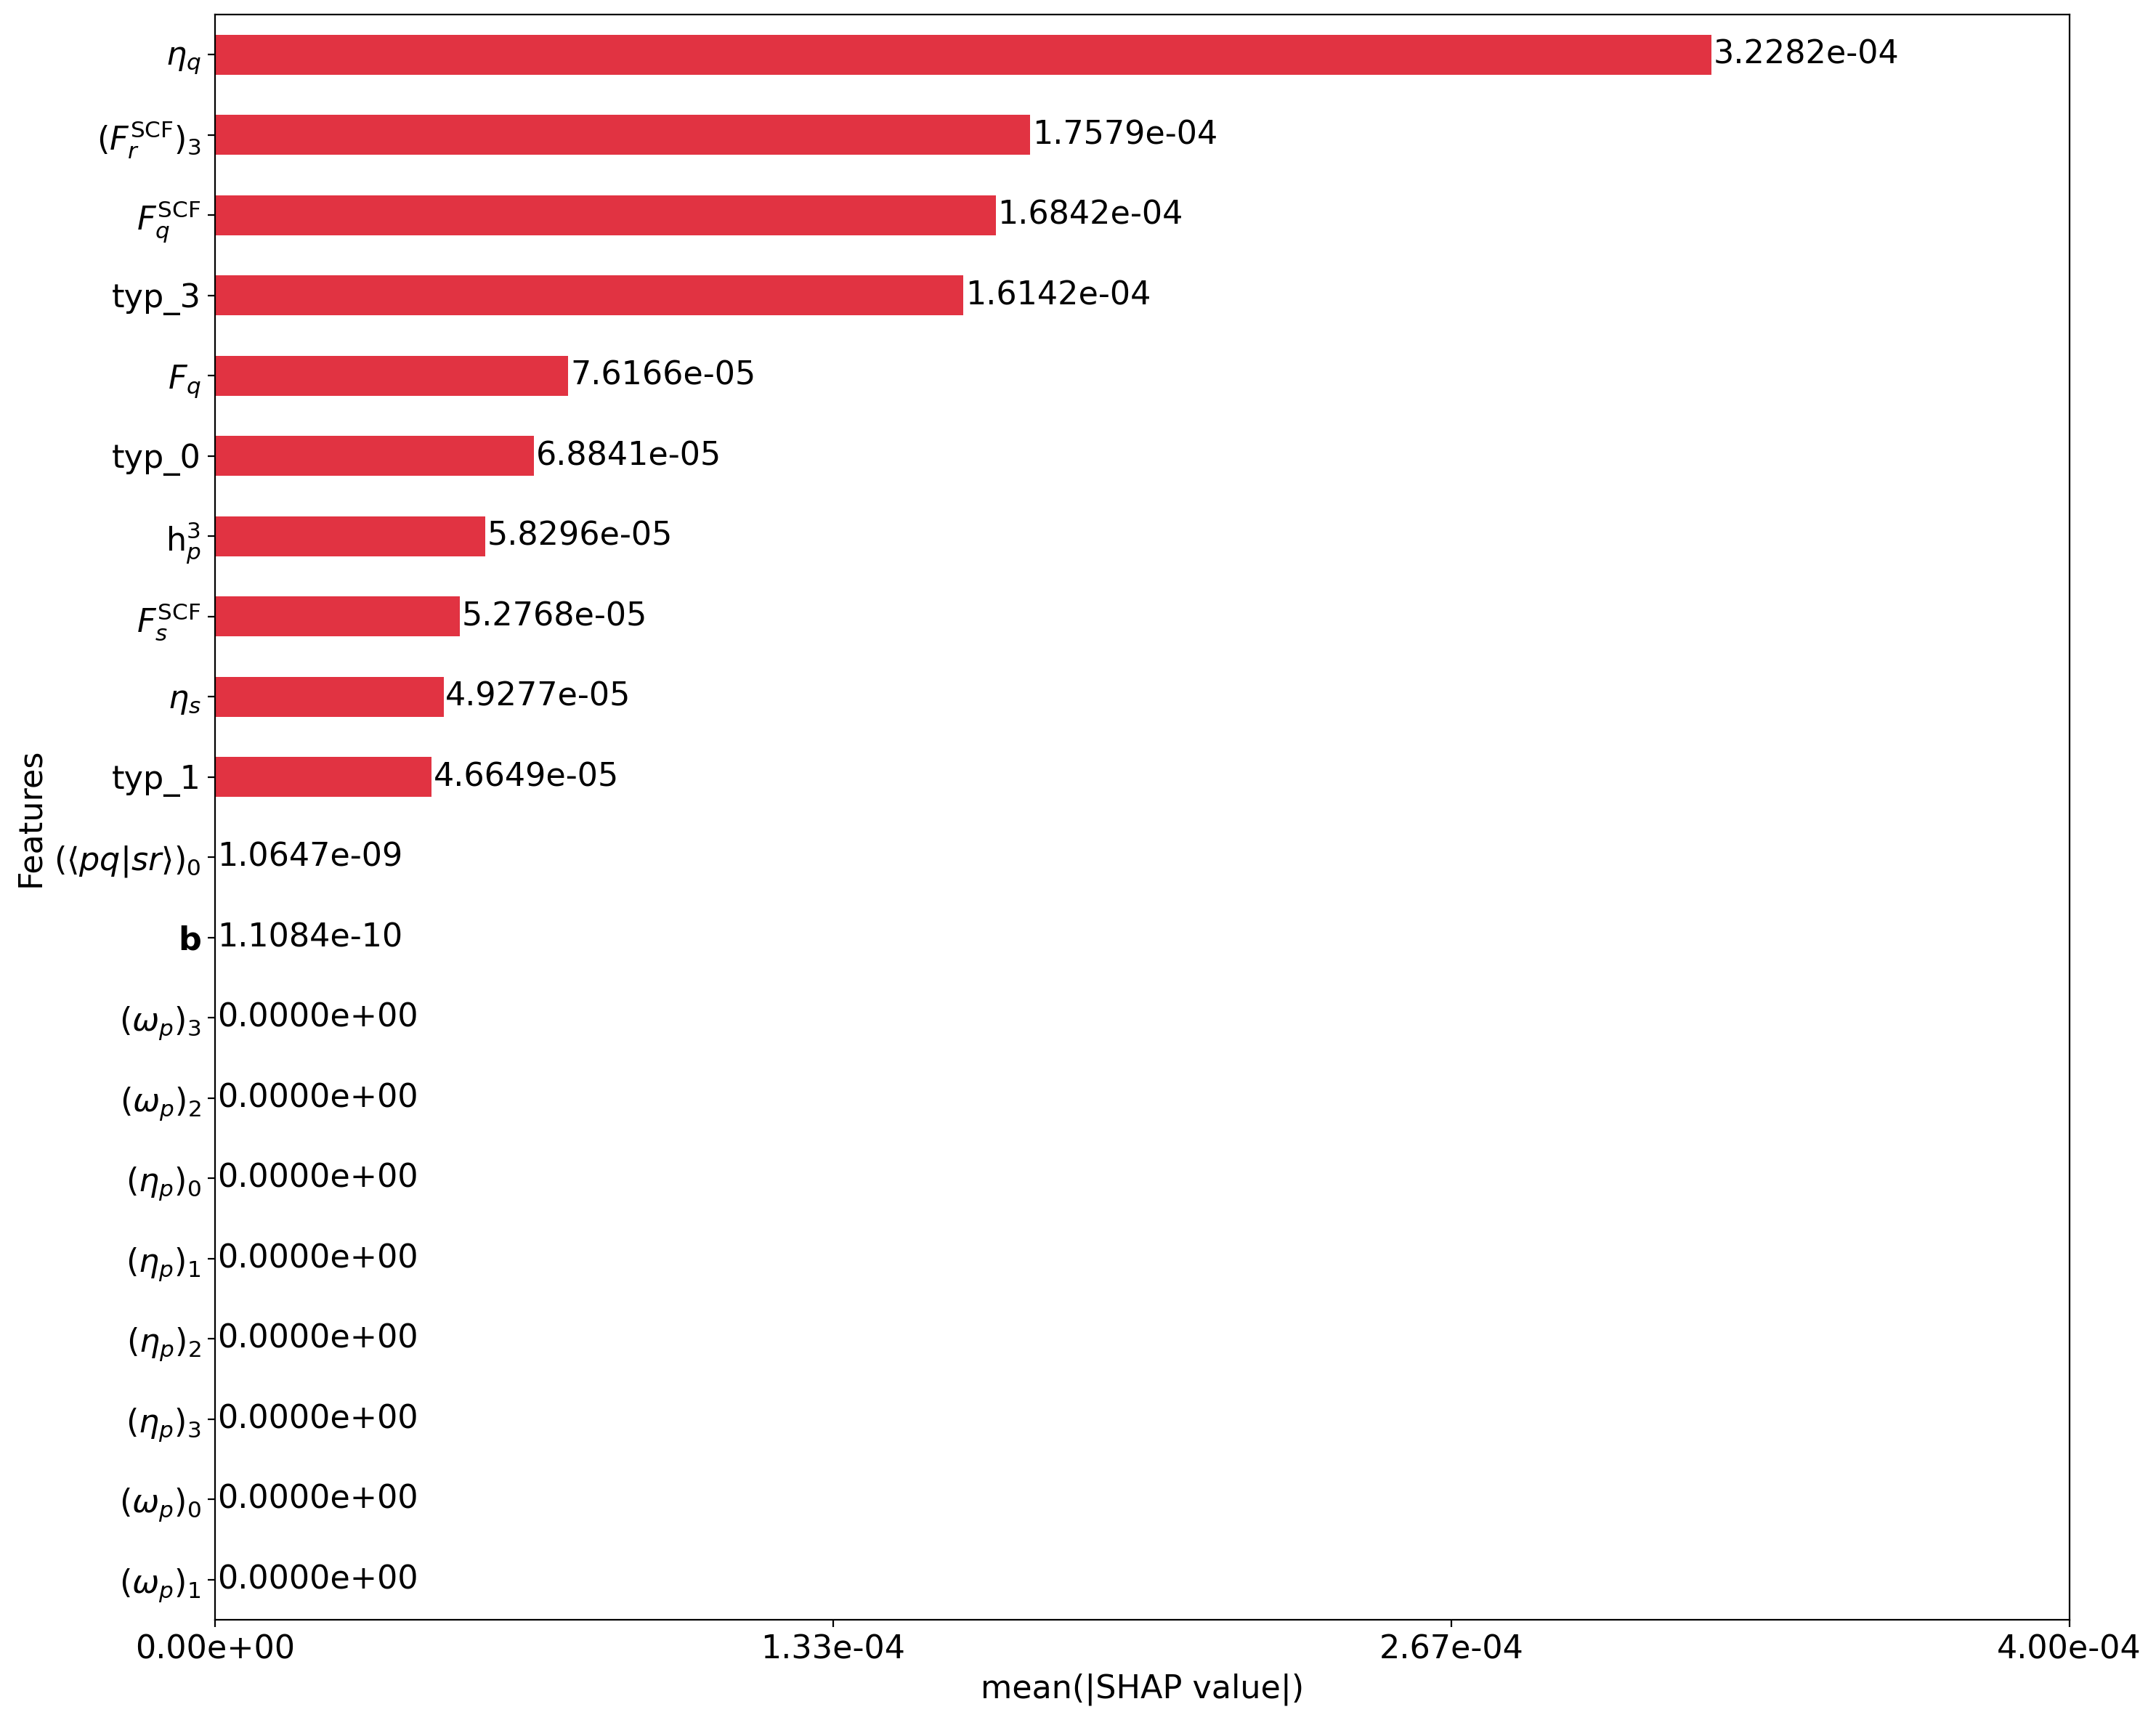

In [45]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
fontsize = 16
pd.concat([dffeat.sort_values(by='shap').iloc[0:10],dffeat.sort_values(by='shap').iloc[-10:]]).plot.barh(x='feat',y='shap',legend=False,color=color_map[3],fontsize=fontsize,ax=ax)
ax.bar_label(ax.containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
top_max = 4e-4
ax.set_xlim(0,top_max)
ax.set_xticks(np.linspace(0,top_max,4),[f"{i:.2e}" for i in np.linspace(0,top_max,4)])
ax.set_ylabel('Features',fontsize=fontsize)
ax.set_xlabel('mean(|SHAP value|)',fontsize=fontsize)

fig.subplots_adjust(wspace=0, hspace=0)

plt.tight_layout()
plt.savefig('images/minmax_Hn_shap_bar.png',dpi=300, bbox_inches='tight')
plt.show()

In [35]:
# # plt.figure(figsize=(8,13))
# color_map=sns.color_palette('rocket',6)
# fontsize = 5

# feat_2 = dffeat.sort_values(by=['shap','feat']).iloc[:63]
# feat_1 = dffeat.sort_values(by=['shap','feat']).iloc[63:]


# ax1=feat_1.sort_values(by=['shap','feat']).plot.barh(x='feat',y='shap',legend=False,color=color_map[3],fontsize=fontsize,ax=ax1)
# ax1.bar_label(ax1.containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
# ax1.set_xlim(0,5e-4)
# ax1.set_xticks(np.linspace(0,5e-4,4),[f"{i:.2e}" for i in np.linspace(0,5e-4,4)])
# ax1.set_ylabel('Features',fontsize=fontsize)
# ax1.set_xlabel('mean(|SHAP value|)',fontsize=fontsize)

# ax2=feat_2.sort_values(by=['shap','feat']).plot.barh(x='feat',y='shap',legend=False,color=color_map[3],fontsize=fontsize,ax=ax2)
# ax2.bar_label(ax2.containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
# ax2.set_xlim(0,5e-4)
# ax2.set_xticks(np.linspace(0,5e-4,4),[f"{i:.2e}" for i in np.linspace(0,5e-4,4)])
# ax2.set_ylabel('')
# ax2.set_xlabel('mean(|SHAP value|)',fontsize=fontsize)

# plt.tight_layout()
# # os.mkdir('images')
# plt.savefig('images/Hn_shap_bar.png',dpi=300, bbox_inches='tight')
# plt.show()



In [36]:
traincorrE2.columns

Index(['H$_{2n}$', 'Radius ($\AA$)', 'E$_{2}^{\text{Calculated}}$',
       'E$_{2}^{\text{Predicted}}$', 'E$_{\text{CASPT2}}^{\text{Calculated}}$',
       'E$_{\text{CASSCF}}^{\text{Calculated}}$', 'E2',
       'E$_{\text{CASPT2}}^{\text{Predicted}}$'],
      dtype='object')

In [37]:
r2_score(traincorrE2['E$_{2}^{\text{Calculated}}$'],traincorrE2['E$_{2}^{\text{Predicted}}$'])

0.999027220639359

In [38]:
mean_absolute_error(traincorrE2['E$_{2}^{\text{Calculated}}$'],traincorrE2['E$_{2}^{\text{Predicted}}$'])*1e3

np.float64(0.5752564792828012)

In [39]:
r2_score(testcorrE2['E$_{2}^{\text{Calculated}}$'],testcorrE2['E$_{2}^{\text{Predicted}}$'])

0.9958443406086348

In [40]:
mean_absolute_error(testcorrE2['E$_{2}^{\text{Calculated}}$'],testcorrE2['E$_{2}^{\text{Predicted}}$'])*1e3

np.float64(1.0748805986562684)

In [41]:
r2_score(traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])

0.9999997442653675

In [42]:
r2_score(testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])

0.9999986795456647

In [43]:
mean_absolute_error(traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(0.5752539754040886)

In [44]:
mean_absolute_error(testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(1.0749031665142728)